In [1]:
# !pip install numpy==1.16.1
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score


In [2]:
n = 5
save_name = f'clinical_history_{n}_observations'
identifier = '20231026_084723_925028'



In [3]:
path_predictions = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/predictions.npz'
path_auc = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/auroc_score.npz'
path_truths = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/truths.npz'
path_losses = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/losses.npz'

### plot losses

In [4]:
## bestaat uit 5x 2 lijsten. elke lijst heeft 50 waardes, 1 voor training en 1 voor validation
losses = np.load(path_losses, allow_pickle=True)#load(path_predictions)
keys = losses.keys()
for key in keys:
    print(f"Key: {key}")
    
    print(losses[key].shape)
    # print(losses[key])


Key: losses
(5, 2)


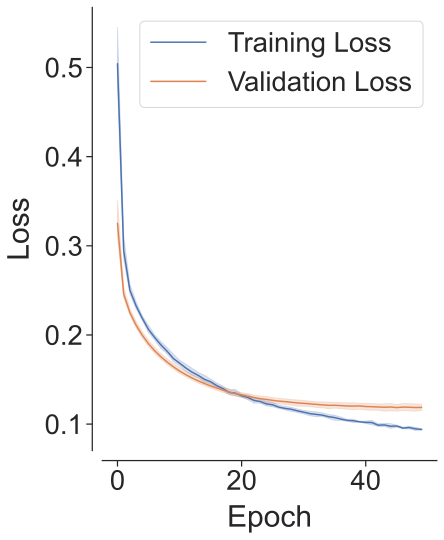

In [5]:
df = pd.DataFrame(losses['losses'],columns=['Loss','valloss'])
# pd.concat([df['Loss'].apply(pd.Series), df['valloss']], axis = 1)
loss_df = df['Loss'].apply(pd.Series).T
loss_df = loss_df.reset_index()
loss_df.columns = ['Epoch','fold1','fold2','fold3','fold4','fold5']
loss_melted = pd.melt(loss_df, id_vars=['Epoch'],
        value_vars=['fold1','fold2','fold3','fold4','fold5'],
       var_name='Fold', value_name='Training Loss')

val_loss_df = df['valloss'].apply(pd.Series).T
val_loss_df = val_loss_df.reset_index()
val_loss_df.columns = ['Epoch','fold1','fold2','fold3','fold4','fold5']
# display(loss_df)
val_loss_melted = pd.melt(val_loss_df, id_vars=['Epoch'],
        value_vars=['fold1','fold2','fold3','fold4','fold5'],
       var_name='Fold', value_name='Validation Loss')
# display(loss_melted)  

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(style="ticks", font_scale=2.5)

fig, ax = plt.subplots(figsize=(6, 8))
sns.lineplot(data=loss_melted, x="Epoch", y="Training Loss", palette = 'blue', label="Training Loss")
sns.lineplot(data=val_loss_melted, x="Epoch", y="Validation Loss", palette = 'steelblue', label="Validation Loss")
# sns.barplot(x=full_report_melted.index, y="value", hue="metric", data=full_report_melted, ax=ax,palette = 'Blues')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel("Epoch",labelpad=10)
ax.set_ylabel("Loss",labelpad=10)

plt.suptitle(None)
# ax.set_ylim(0,1)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
sns.despine(offset=10, trim=False)
plt.legend(loc='upper right')
output_path_png = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/loss_{identifier}.png'
output_path_pdf = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/loss_{identifier}.pdf'
fig.savefig(output_path_png,bbox_inches="tight",dpi=600) 
fig.savefig(output_path_pdf,bbox_inches="tight",dpi=600) 
plt.show()
plt.close()

#### AUROC
TO DO; AUROC score per diagnosis? possible?

In [11]:
auroc = np.load(path_auc, allow_pickle=True)#load(path_predictions)
keys = auroc.keys()
for key in keys:
    print(f"Key: {key}")
    print(auroc[key].shape)
    print(auroc[key])
averages = []
for i in range(5):
    print(i)
    averages.append(auroc['auc_score_list_all'][i][2])
print(averages)
average_auroc = np.average(averages)
print(average_auroc)

Key: auc_score_list_all
(5, 3)
[[0.98278105 0.93201987 0.93828781]
 [0.98245993 0.9244444  0.91731412]
 [0.98682696 0.93239958 0.94867039]
 [0.98473964 0.9267526  0.9281235 ]
 [0.98416389 0.94619859 0.9233108 ]]
0
1
2
3
4
[0.938287811110894, 0.9173141157279382, 0.9486703873408447, 0.9281234963804955, 0.9233108033477057]
0.9311413227815757


#### PREDICTIONS
one array for each fold. Then per fold we get the results for train, validate, and test. 


In [12]:
## voor elke fold
## pred_y_list met predicties voor train, val, en test
## de predicties zijn een array. voor elke donor is er een rij. 
## de rij bestaat uit 12 kolommen, 1 voor elke diagnose
## we kunnen de predicties voor de test data combineren, en zo voor elke donor een predictie krijgen
donorindex = pd.read_excel("/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/data/clinical_history_5_observations/donorindexes.xlsx" )
wanted = ['CON', 'AD', 'PD', 'VD', 'FTD','DLB','AD,DLB','ATAXIA', 'MND', 'PSP', 'MS','MSA']
# display(donorindex)

######## ACCESSING THE PREDICTIONS AND ADDING DONORID
pred_dict = []
preds = np.load(path_predictions, allow_pickle=True)
keys = preds.keys()
for key in keys:
    print(preds[key].shape)
    for i in range(len(preds[key])):
        # display(preds[key][i][2].shape)
        preds_df = pd.DataFrame(preds[key][i][2],columns = wanted)
        preds_df['fold'] = i
        
        folddonors = list(donorindex[donorindex['foldinfo']==i]['DonorID'])
        preds_df['DonorID'] = folddonors
        # display(truth_df)
        pred_dict.append(preds_df)
        
preds_df_all = pd.concat(pred_dict, ignore_index=True)
preds_df_all['pred'] = preds_df_all.iloc[:, :12].apply(lambda row: row.idxmax(), axis=1)  
preds_df_all = preds_df_all[['DonorID','pred']]
# display(preds_df_all)

######## ACCESSING THE TRUTHS AND ADDING DONORID
truth_dict = []
truths = np.load(path_truths, allow_pickle=True)
keys = truths.keys()
for key in keys:
    for j in range(len(truths[key])):
        # display(truths[key][j][2].shape)
        truth_df = pd.DataFrame(truths[key][j][2],columns = wanted)
        truth_df['fold'] = j
        
        folddonors = list(donorindex[donorindex['foldinfo']==j]['DonorID'])
        testdiag = list(donorindex[donorindex['foldinfo']==j]['simplified_diagnosis'])
        truth_df['DonorID'] = folddonors
        truth_df['testdiag'] = testdiag
        # display(truth_df)
        truth_dict.append(truth_df)
        
truths_df_all = pd.concat(truth_dict, ignore_index=True)
truths_df_all['neuropathological_diagnosis'] = truths_df_all.iloc[:, :12].apply(lambda row: row.idxmax(), axis=1)
truths_df_all = truths_df_all[['DonorID','neuropathological_diagnosis']]

prediction_evaluation = pd.merge(preds_df_all, truths_df_all, on='DonorID', how='inner')
prediction_evaluation['neuropathological_diagnosis'] = prediction_evaluation['neuropathological_diagnosis'].replace('AD,DLB', 'AD-DLB')
prediction_evaluation['pred'] = prediction_evaluation['pred'].replace('AD,DLB', 'AD-DLB')
display(prediction_evaluation)


(5, 3)


,DonorID,pred,neuropathological_diagnosis
0,NBB 1997-006,MS,MS
1,NBB 1997-008,CON,CON
2,NBB 1997-009,AD,AD
3,NBB 1997-026,AD,AD
4,NBB 1997-030,AD,AD
...,...,...,...
1805,NBB 2019-124,AD,DLB
1806,NBB 2019-131,PD,MSA
1807,NBB 2020-018,PD,PD
1808,NBB 2020-029,FTD,PSP


### confusion matrix

                             counts
neuropathological_diagnosis        
CON                             314
AD                              477
PD                              237
VD                               53
FTD                             196
DLB                              30
AD-DLB                          103
ATAXIA                           19
MND                              16
PSP                              86
MS                              222
MSA                              57


pred,AD,AD-DLB,ATAXIA,CON,FTD,MND,MS,MSA,PD,PSP,VD
neuropathological_diagnosis,,,,,,,,,,,
AD,426,1,0,12,25,0,0,1,10,2,0
AD-DLB,82,2,0,3,6,0,0,0,8,2,0
ATAXIA,5,0,2,1,1,0,1,4,1,4,0
CON,6,0,0,294,0,0,13,0,1,0,0
DLB,15,0,0,2,1,0,0,0,12,0,0
FTD,53,0,0,1,133,0,1,2,2,4,0
MND,0,0,0,1,2,3,5,5,0,0,0
MS,2,0,0,16,0,0,203,0,0,0,1
MSA,1,0,0,0,0,0,1,25,24,6,0


,CON,AD,PD,VD,FTD,DLB,AD-DLB,ATAXIA,MND,PSP,MS,MSA
CON,93.630573,1.910828,0.318471,0.000000,0.000000,0,0.000000,0.000000,0.00,0.000000,4.140127,0.000000
AD,2.515723,89.308176,2.096436,0.000000,5.241090,0,0.209644,0.000000,0.00,0.419287,0.000000,0.209644
PD,1.265823,3.797468,89.873418,0.000000,0.843882,0,0.000000,0.000000,0.00,2.953586,0.000000,1.265823
VD,26.415094,30.188679,5.660377,3.773585,3.773585,0,0.000000,0.000000,0.00,0.000000,30.188679,0.000000
FTD,0.510204,27.040816,1.020408,0.000000,67.857143,0,0.000000,0.000000,0.00,2.040816,0.510204,1.020408
DLB,6.666667,50.000000,40.000000,0.000000,3.333333,0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
AD-DLB,2.912621,79.611650,7.766990,0.000000,5.825243,0,1.941748,0.000000,0.00,1.941748,0.000000,0.000000
ATAXIA,5.263158,26.315789,5.263158,0.000000,5.263158,0,0.000000,10.526316,0.00,21.052632,5.263158,21.052632
MND,6.250000,0.000000,0.000000,0.000000,12.500000,0,0.000000,0.000000,18.75,0.000000,31.250000,31.250000
PSP,0.000000,11.627907,22.093023,0.000000,17.441860,0,0.000000,0.000000,0.00,45.348837,0.000000,3.488372


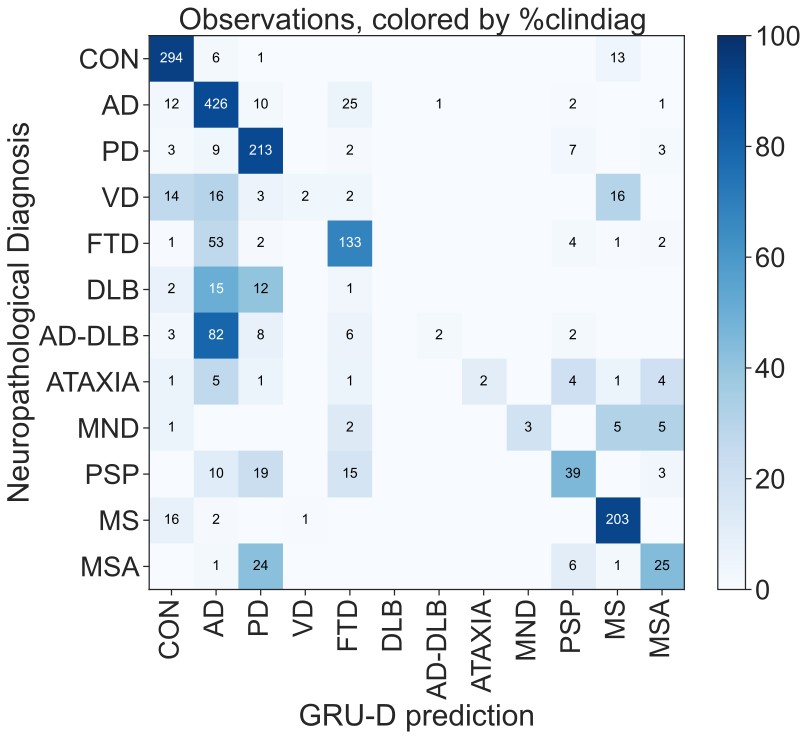

In [13]:
cf = prediction_evaluation.copy()
# cf['clinical_diagnosis'] = cf['clinical_diagnosis'].str.split(',')
cf = cf.explode('pred')
# display(cf)
# display(cf['pred'].value_counts())
# display(cf['neuropathological_diagnosis'].value_counts())
total_true_diagnoses = pd.DataFrame(cf['neuropathological_diagnosis'].value_counts())
total_true_diagnoses.reset_index(inplace=True)
total_true_diagnoses.columns = ['neuropathological_diagnosis', 'counts']
# print(total_true_diagnoses)
# display(cf.head(10))
confusion_matrix = pd.crosstab(cf['neuropathological_diagnosis'], cf['pred'])
# Define the custom order of diagnosis categories
# wantedy = ['AD', 'PD', 'VD', 'FTD', 'DLB', 'AD-DLB', 'ATAXIA', 'MND', 'PSP', 'MS', 'MSA', 'other']
wantedx = ['CON','AD', 'PD', 'VD', 'FTD', 'DLB', 'AD-DLB', 'ATAXIA', 'MND', 'PSP', 'MS', 'MSA']


total_true_diagnoses = total_true_diagnoses.set_index('neuropathological_diagnosis')
total_true_diagnoses = total_true_diagnoses.reindex(wantedx)
print(total_true_diagnoses)
### observations, colored by % of clindiag
# total_true_diagnoses = confusion_matrix.sum(axis=0)
confusion_matrix_percentage = confusion_matrix.div(total_true_diagnoses['counts'], axis=0) * 100
display(confusion_matrix)
for diag in wantedx:
    if diag not in confusion_matrix.columns:
        # Add a dummy column for 'DLB' with all zeros
        confusion_matrix_percentage[diag] = 0
        confusion_matrix_percentage[diag] = confusion_matrix_percentage[diag].astype(int)
        confusion_matrix[diag] = 0
        confusion_matrix[diag] = confusion_matrix[diag].astype(int)
# Convert the index and columns of the confusion_matrix DataFrame to a Categorical type with the custom order
confusion_matrix_percentage.index = pd.Categorical(confusion_matrix_percentage.index, categories=wantedx)
confusion_matrix_percentage.columns = pd.Categorical(confusion_matrix_percentage.columns, categories=wantedx)
confusion_matrix_percentage = confusion_matrix_percentage.sort_index(axis=0).sort_index(axis=1)
confusion_matrix.index = pd.Categorical(confusion_matrix.index, categories=wantedx)
confusion_matrix.columns = pd.Categorical(confusion_matrix.columns, categories=wantedx)
confusion_matrix = confusion_matrix.sort_index(axis=0).sort_index(axis=1)

# display(confusion_matrix)
display(confusion_matrix_percentage)
plt.figure(figsize=(12, 10))
plt.imshow(confusion_matrix_percentage, cmap=plt.cm.Blues, aspect='auto',interpolation='nearest',vmin=0, vmax=100)
plt.colorbar()
plt.xlabel('GRU-D prediction')
plt.ylabel('Neuropathological Diagnosis')
plt.title('Observations, colored by %clindiag ')
tick_labels_x = confusion_matrix_percentage.columns
tick_labels_y = confusion_matrix_percentage.index
plt.xticks(range(len(tick_labels_x)), tick_labels_x, rotation=90)
plt.yticks(range(len(tick_labels_y)), tick_labels_y)
for i in range(len(tick_labels_y)):
    for j in range(len(tick_labels_x)):
        value = round(confusion_matrix.iloc[i, j])
        value_p = round(confusion_matrix_percentage.iloc[i, j])
        if value > 0:
            text_color = 'white' if value_p >= 50 else 'black'
            plt.text(j, i, f'{value}', ha='center', va='center', color=text_color, fontsize=14)
plt.savefig('/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/figures/grud_confusion_matric.pdf', format='pdf', dpi=600)            
plt.show()

### compare with clinical diagnosis

In [14]:
clinical = pd.read_excel("/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/data/grud_clin_subset_overview.xlsx" )
clinical_full = pd.read_excel('/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/data/grud_clin_subset_with_clinical_diagnoses.xlsx' )
# display(clinical['neuropathological_diagnosis'].value_counts())
display(prediction_evaluation['neuropathological_diagnosis'].value_counts())
clinical_full.head()

AD        477
CON       314
PD        237
MS        222
FTD       196
AD-DLB    103
PSP        86
MSA        57
VD         53
DLB        30
ATAXIA     19
MND        16
Name: neuropathological_diagnosis, dtype: int64

,Origin,DonorID,Year,clinical_diagnosis,neuropathological_diagnosis,simplified_diagnosis,clinical_diagnosis_raw,table1diag,parsed_clinical_diagnosis
0,part1,NBB 1997-001,1988,Alzheimer's disease,AD,AD,Alzheimer's disease,Alzheimer's disease,AD
1,part1,NBB 1997-001,1992,Parkinsonism,AD,AD,Parkinsonism,not_relevant,AD
2,part2,NBB 1997-002,year unknown,not_relevant,CON,CON,not_relevant,not_relevant,other
3,part1,NBB 1997-003,year unknown,Alzheimer's disease,AD,AD,Alzheimer's disease,Alzheimer's disease,AD
4,part1,NBB 1997-003,year unknown,dementia,AD,AD,dementia,not_relevant,AD


## clinical confusion matrix

In [15]:
clinical

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis
0,NBB 1997-001,AD,AD
1,NBB 1997-002,CON,other
2,NBB 1997-003,AD,AD
3,NBB 1997-005,CON,other
4,NBB 1997-006,MS,MS
...,...,...,...
1805,NBB 2020-029,PSP,FTD
1806,NBB 2020-030,MSA,PD
1807,NBB 2020-052,CON,other
1808,NBB 2020-054,CON,other


                             counts
neuropathological_diagnosis        
CON                             315
AD                              519
PD                              274
VD                               59
FTD                             222
DLB                              36
AD-DLB                          112
ATAXIA                           20
MND                              16
PSP                             108
MS                              225
MSA                              79


,dementia,other,AD,PD,VD,FTD,DLB,AD-DLB,ATAXIA,MND,PSP,MS,MSA
CON,0.634921,97.777778,0.000000,0.317460,0.317460,0.000000,0.000000,0.317460,0.000000,0.000000,0.634921,0.000000,0.000000
AD,13.487476,5.973025,63.391137,0.578035,8.863198,5.009634,1.541426,0.385356,0.000000,0.385356,0.192678,0.000000,0.192678
PD,0.364964,1.824818,1.824818,78.832117,2.554745,0.364964,7.299270,0.729927,0.000000,0.000000,1.094891,0.000000,5.109489
VD,6.779661,20.338983,18.644068,5.084746,37.288136,8.474576,0.000000,0.000000,0.000000,0.000000,0.000000,1.694915,1.694915
FTD,0.900901,5.405405,11.711712,1.351351,2.252252,72.072072,0.450450,0.000000,0.000000,4.504505,0.450450,0.000000,0.900901
DLB,5.555556,13.888889,5.555556,11.111111,2.777778,2.777778,50.000000,2.777778,0.000000,0.000000,0.000000,0.000000,5.555556
AD-DLB,14.285714,4.464286,48.214286,2.678571,7.142857,7.142857,11.607143,2.678571,0.000000,0.000000,0.000000,0.892857,0.892857
ATAXIA,5.000000,20.000000,5.000000,0.000000,0.000000,5.000000,0.000000,0.000000,35.000000,5.000000,5.000000,5.000000,15.000000
MND,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
PSP,3.703704,10.185185,5.555556,19.444444,1.851852,9.259259,0.000000,0.000000,0.000000,0.925926,45.370370,0.000000,3.703704


,dementia,other,AD,PD,VD,FTD,DLB,AD-DLB,ATAXIA,MND,PSP,MS,MSA
CON,2,308,0,1,1,0,0,1,0,0,2,0,0
AD,70,31,329,3,46,26,8,2,0,2,1,0,1
PD,1,5,5,216,7,1,20,2,0,0,3,0,14
VD,4,12,11,3,22,5,0,0,0,0,0,1,1
FTD,2,12,26,3,5,160,1,0,0,10,1,0,2
DLB,2,5,2,4,1,1,18,1,0,0,0,0,2
AD-DLB,16,5,54,3,8,8,13,3,0,0,0,1,1
ATAXIA,1,4,1,0,0,1,0,0,7,1,1,1,3
MND,0,0,0,0,0,0,0,0,0,16,0,0,0
PSP,4,11,6,21,2,10,0,0,0,1,49,0,4


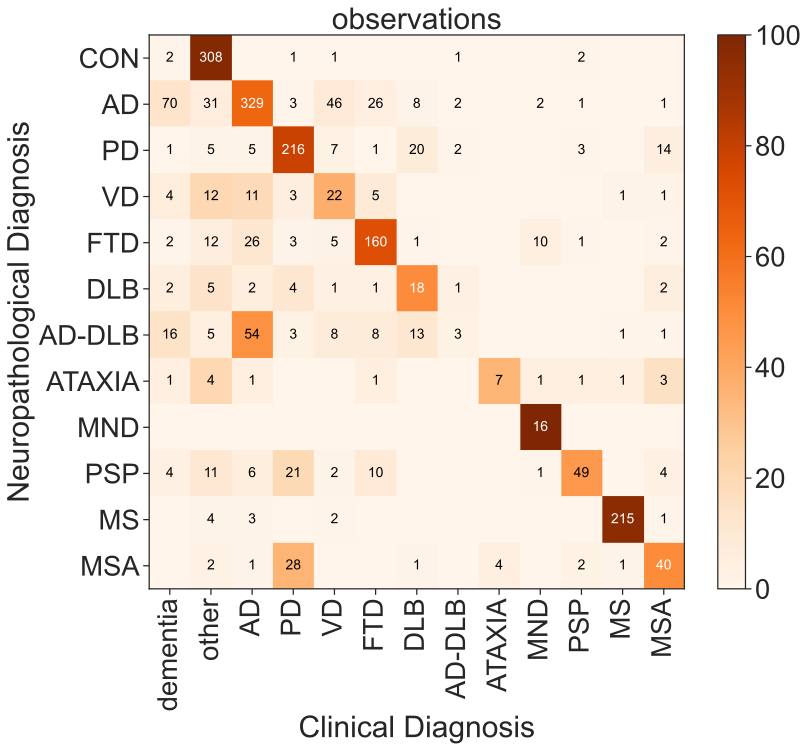

In [16]:
cf = clinical.copy()
cf['parsed_clinical_diagnosis'] = cf['parsed_clinical_diagnosis'].str.split(',')
cf = cf.explode('parsed_clinical_diagnosis')
total_true_diagnoses = pd.DataFrame(cf['neuropathological_diagnosis'].value_counts())
total_true_diagnoses.reset_index(inplace=True)
total_true_diagnoses.columns = ['neuropathological_diagnosis', 'counts']
# print(total_true_diagnoses)
confusion_matrix = pd.crosstab(cf['neuropathological_diagnosis'], cf['parsed_clinical_diagnosis'])
# Define the custom order of diagnosis categories
wantedy = ['dementia','other','AD', 'PD', 'VD', 'FTD', 'DLB', 'AD-DLB', 'ATAXIA', 'MND', 'PSP', 'MS', 'MSA']
wantedx = ['CON','AD', 'PD', 'VD', 'FTD', 'DLB', 'AD-DLB', 'ATAXIA', 'MND', 'PSP', 'MS', 'MSA']

# Convert the index and columns of the confusion_matrix DataFrame to a Categorical type with the custom order
confusion_matrix.index = pd.Categorical(confusion_matrix.index, categories=wantedx)
confusion_matrix.columns = pd.Categorical(confusion_matrix.columns, categories=wantedy)
confusion_matrix = confusion_matrix.sort_index(axis=0).sort_index(axis=1)
# display(confusion_matrix)

### percentages of true NP
total_true_diagnoses = total_true_diagnoses.set_index('neuropathological_diagnosis')
total_true_diagnoses = total_true_diagnoses.reindex(wantedx)
print(total_true_diagnoses)
confusion_matrix_percentage = confusion_matrix.div(total_true_diagnoses['counts'], axis=0) * 100
display(confusion_matrix_percentage)
display(confusion_matrix)
plt.figure(figsize=(12, 10))
plt.imshow(confusion_matrix_percentage, cmap=plt.cm.Oranges, aspect='auto',interpolation='nearest',vmin=0, vmax=100)
plt.colorbar()
plt.xlabel('Clinical Diagnosis')
plt.ylabel('Neuropathological Diagnosis')
plt.title('observations')
tick_labels_x = confusion_matrix.columns
tick_labels_y = confusion_matrix.index
plt.xticks(range(len(tick_labels_x)), tick_labels_x, rotation=90)
plt.yticks(range(len(tick_labels_y)), tick_labels_y)
for i in range(len(tick_labels_y)):
    for j in range(len(tick_labels_x)):
        value = round(confusion_matrix.iloc[i, j])
        valuep = round(confusion_matrix_percentage.iloc[i, j])
        if value > 0:
            text_color = 'white' if valuep >= 50 else 'black'
            plt.text(j, i, f'{value}', ha='center', va='center', color=text_color, fontsize=14)

plt.savefig('/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/figures/clinical_confusion_matric.pdf', format='pdf', dpi=600)
plt.show()



In [17]:
both = pd.merge(clinical, prediction_evaluation, on=['DonorID','neuropathological_diagnosis'], how='inner')
both_full = pd.merge(clinical_full, prediction_evaluation, on=['DonorID','neuropathological_diagnosis'], how='inner')
# display(both['neuropathological_diagnosis'].value_counts())
display(both)

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred
0,NBB 1997-001,AD,AD,AD
1,NBB 1997-002,CON,other,CON
2,NBB 1997-003,AD,AD,AD
3,NBB 1997-005,CON,other,CON
4,NBB 1997-006,MS,MS,MS
...,...,...,...,...
1805,NBB 2020-029,PSP,FTD,FTD
1806,NBB 2020-030,MSA,PD,PD
1807,NBB 2020-052,CON,other,MS
1808,NBB 2020-054,CON,other,MS


In [18]:

# 

### venn cd vs nd

In [19]:
display(both)#['parsed_clinical_diagnosis'].value_counts())

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred
0,NBB 1997-001,AD,AD,AD
1,NBB 1997-002,CON,other,CON
2,NBB 1997-003,AD,AD,AD
3,NBB 1997-005,CON,other,CON
4,NBB 1997-006,MS,MS,MS
...,...,...,...,...
1805,NBB 2020-029,PSP,FTD,FTD
1806,NBB 2020-030,MSA,PD,PD
1807,NBB 2020-052,CON,other,MS
1808,NBB 2020-054,CON,other,MS


In [20]:
new_both = both.copy()
new_both['clin_coherence'] = 'unknown/coherent'

'AD'

 jaccard strict: 0.5254545454545455
All donors lenient: 625
ND only strict 188
ND only lenient 76
clin only strict 73
clin only lenient 75
clin only total 148
clin + ND strict 289
clin + ND lenient 112
clin + ND total 401
625
550
 jaccard lenient: 0.6416
 % ND 84 
 % CD 73 


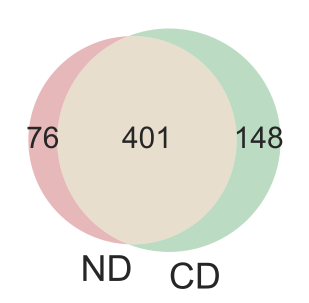

'FTD'

 jaccard strict: 0.6098654708520179
All donors lenient: 348
ND only strict 60
ND only lenient 34
clin only strict 27
clin only lenient 125
clin only total 152
clin + ND strict 136
clin + ND lenient 26
clin + ND total 162
348
223
 jaccard lenient: 0.46551724137931033
 % ND 83 
 % CD 52 


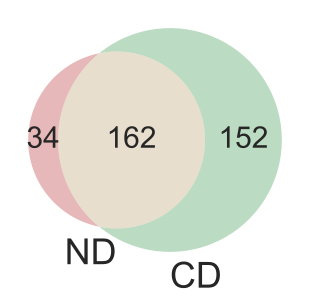

'VD'

 jaccard strict: 0.20930232558139536
All donors lenient: 223
ND only strict 35
ND only lenient 27
clin only strict 33
clin only lenient 137
clin only total 170
clin + ND strict 18
clin + ND lenient 8
clin + ND total 26
223
86
 jaccard lenient: 0.11659192825112108
 % ND 49 
 % CD 13 


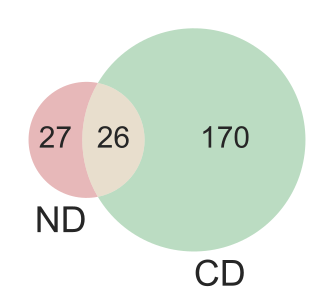

'DLB'

 jaccard strict: 0.23529411764705882
All donors lenient: 181
ND only strict 18
ND only lenient 9
clin only strict 21
clin only lenient 130
clin only total 151
clin + ND strict 12
clin + ND lenient 9
clin + ND total 21
181
51
 jaccard lenient: 0.11602209944751381
 % ND 70 
 % CD 12 


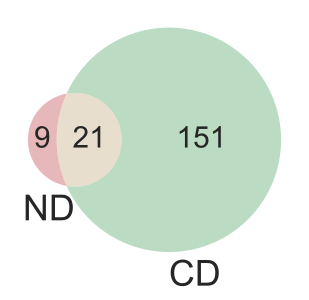

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred,clin_coherence
40,NBB 1997-071,AD,VD,AD,non_coherent
41,NBB 1997-072,PSP,"PD,PSP",PD,unknown/coherent
42,NBB 1997-073,MS,MS,MS,unknown/coherent
43,NBB 1997-074,AD,AD,AD,unknown/coherent
44,NBB 1997-076,AD,AD,AD,unknown/coherent
45,NBB 1997-077,MS,MS,MS,unknown/coherent
46,NBB 1997-085,CON,other,CON,unknown/coherent
47,NBB 1997-086,AD,"AD,VD",AD,unknown/coherent
48,NBB 1997-087,AD,AD,AD,unknown/coherent
49,NBB 1997-088,CON,other,CON,unknown/coherent


In [21]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2
venndiagnoses = ['AD','FTD','VD','DLB']
# venndiagnoses = ['AD']
for i in venndiagnoses:
    display(i)
    ## STRICT
    venndf = both[(both['neuropathological_diagnosis'] == i) | (both['parsed_clinical_diagnosis'] == i)]
    # display(venndf)
    nponly_s = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['parsed_clinical_diagnosis'] != i)]
    # display(nponly_s)
    # display(len(nponly_s))
    clinonly_s = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] == i))]
    # display(clinonly_s)
    clinndset_s = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'] == i))]
    # display(clinndset_s)
    print(f" jaccard strict: {len(clinndset_s)/(len(nponly_s)+len(clinonly_s)+len(clinndset_s))}")

    ### LENIENT
    venndf = both[(both['neuropathological_diagnosis'] == i) | (both['parsed_clinical_diagnosis'].str.contains(i)) | \
                   (both['parsed_clinical_diagnosis'] =='dementia') ]
    print(f"All donors lenient: {len(venndf)}")
    nponly = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((~venndf['parsed_clinical_diagnosis'].str.contains(i)) & (venndf['parsed_clinical_diagnosis']!='dementia'))]
    # display(nponly)
    clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | (venndf['parsed_clinical_diagnosis']=='dementia'))]
    # display(clinonly)
    clinndset = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | (venndf['parsed_clinical_diagnosis']=='dementia'))]
    # display(clinndset)
    new_both.loc[new_both['DonorID'].isin(nponly['DonorID']), 'clin_coherence'] = 'non_coherent'
    # new_both.loc[new_both['DonorID'].isin(clinndset_s['DonorID']), 'clin_coherence'] = 'perfect'
    # display(clinonly['parsed_clinical_diagnosis'].value_counts())
    # x = clinonly.merge(clinonly_s[['DonorID']], on='DonorID', how='left', indicator=True)
    # display(x[x['_merge'] == 'left_only'].drop(columns=['_merge']))
    print(f"ND only strict {len(nponly_s)}")
    print(f"ND only lenient {len(nponly)}")
    print(f"clin only strict {len(clinonly_s)}")
    print(f"clin only lenient {len(clinonly)-len(clinonly_s)}")
    print(f"clin only total {len(clinonly)}")
    print(f"clin + ND strict {len(clinndset_s)}")
    print(f"clin + ND lenient {len(clinndset)-len(clinndset_s)}")
    print(f"clin + ND total {len(clinndset)}")
    print(len(nponly)+len(clinonly)+len(clinndset))
    print(len(nponly_s)+len(clinonly_s)+len(clinndset_s))
    print(f" jaccard lenient: {len(clinndset)/(len(nponly)+len(clinonly)+len(clinndset))}")
    
    print(f" % ND {round(100*len(clinndset)/(len(clinndset)+len(nponly)))} ")
    print(f" % CD {round(100*len(clinndset)/(len(clinndset)+len(clinonly)))} ")

    venn2(subsets = (len(nponly), len(clinonly), len(clinndset)), set_labels = ('ND', 'CD'))
    plt.show()
    print("\n")

display(new_both[40:80])   
# display(new_both['clin_coherence'].value_counts())

'PD'

'length strict: 261'

 jaccard strict: 0.7049808429118773


'length lenient (in figure): 303'

ND only strict 53
ND only lenient (in figure) 21
clin only strict (in figure parentheses) 24
clin only total (in figure) 66
clin + ND strict (in figure parentheses) 184
clin + ND total (in figure) 216
 jaccard lenient (in figure): 0.7128712871287128
 % ND 91 
 % CD 77 


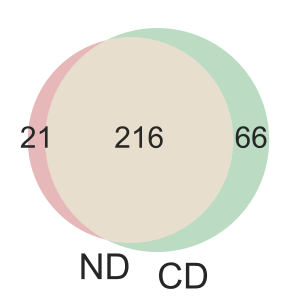

'ATAXIA'

'length strict: 22'

 jaccard strict: 0.3181818181818182


'length lenient (in figure): 23'

ND only strict 12
ND only lenient (in figure) 12
clin only strict (in figure parentheses) 3
clin only total (in figure) 4
clin + ND strict (in figure parentheses) 7
clin + ND total (in figure) 7
 jaccard lenient (in figure): 0.30434782608695654
 % ND 37 
 % CD 64 


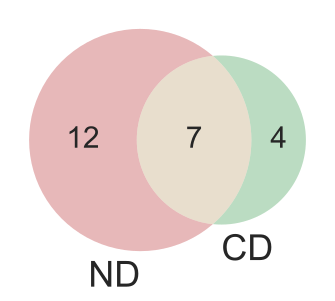

'MND'

'length strict: 19'

 jaccard strict: 0.8421052631578947


'length lenient (in figure): 30'

ND only strict 0
ND only lenient (in figure) 0
clin only strict (in figure parentheses) 3
clin only total (in figure) 14
clin + ND strict (in figure parentheses) 16
clin + ND total (in figure) 16
 jaccard lenient (in figure): 0.5333333333333333
 % ND 100 
 % CD 53 


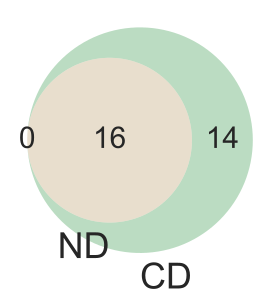

'PSP'

'length strict: 91'

 jaccard strict: 0.34065934065934067


'length lenient (in figure): 96'

ND only strict 55
ND only lenient (in figure) 37
clin only strict (in figure parentheses) 5
clin only total (in figure) 10
clin + ND strict (in figure parentheses) 31
clin + ND total (in figure) 49
 jaccard lenient (in figure): 0.5104166666666666
 % ND 57 
 % CD 83 


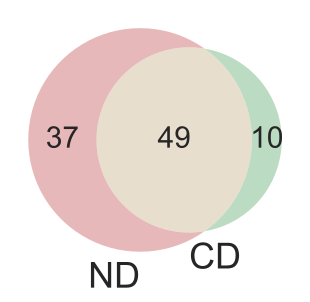

'MSA'

'length strict: 72'

 jaccard strict: 0.2638888888888889


'length lenient (in figure): 86'

ND only strict 38
ND only lenient (in figure) 17
clin only strict (in figure parentheses) 15
clin only total (in figure) 29
clin + ND strict (in figure parentheses) 19
clin + ND total (in figure) 40
 jaccard lenient (in figure): 0.46511627906976744
 % ND 70 
 % CD 58 


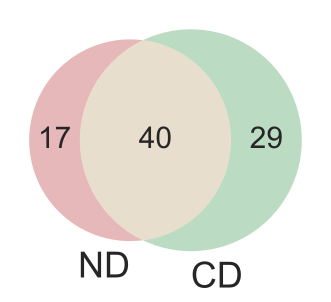

'MS'

'length strict: 224'

 jaccard strict: 0.9508928571428571


'length lenient (in figure): 226'

ND only strict 9
ND only lenient (in figure) 7
clin only strict (in figure parentheses) 2
clin only total (in figure) 4
clin + ND strict (in figure parentheses) 213
clin + ND total (in figure) 215
 jaccard lenient (in figure): 0.9513274336283186
 % ND 97 
 % CD 98 


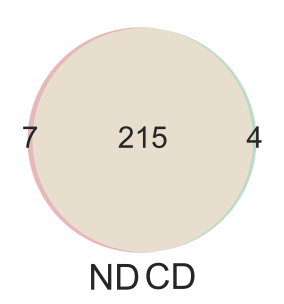

In [22]:
from matplotlib_venn import venn3
# venndiagnoses = ['MS']
venndiagnoses = ['PD','ATAXIA', 'MND', 'PSP', 'MSA','MS']
# venndiagnoses = ['MS']
for i in venndiagnoses:
    display(i)
    ## first we have to select all donors that have AD or dementia in one of the three columns
    venndf = both[(both['neuropathological_diagnosis'] == i) | (both['parsed_clinical_diagnosis'] == i)]
    display(f"length strict: {len(venndf)}")
    nponly_s = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['parsed_clinical_diagnosis'] != i)]
    # display(nponly_s)
    clinonly_s = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] == i))]
    # display(clinonly_s)
    clinndset_s = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'] == i))]
    # display(clinndset_s)
    print(f" jaccard strict: {len(clinndset_s)/(len(nponly_s)+len(clinonly_s)+len(clinndset_s))}")

    venndf = both[(both['neuropathological_diagnosis'] == i) | ((both['parsed_clinical_diagnosis'].str.contains(i)))]
    venndf = both[(both['neuropathological_diagnosis'] == i) | both['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))]
    # display(venndf['parsed_clinical_diagnosis'].value_counts())
    display(f"length lenient (in figure): {len(venndf)}")
    nponly = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')))]
    # display(nponly)
    # clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
    #                       ((venndf['parsed_clinical_diagnosis'].str.contains(i)))]
    clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')))]
    # display(clinonly)
    clinndset = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')))]
    # display(clinndset)
    new_both.loc[new_both['DonorID'].isin(nponly['DonorID']), 'clin_coherence'] = 'non_coherent'
    # new_both.loc[new_both['DonorID'].isin(clinndset_s['DonorID']), 'clin_coherence'] = 'perfect'
    # display(clinonly['parsed_clinical_diagnosis'].value_counts())
    # x = clinonly.merge(clinonly_s[['DonorID']], on='DonorID', how='left', indicator=True)
    # display(x[x['_merge'] == 'left_only'].drop(columns=['_merge']))
    print(f"ND only strict {len(nponly_s)}")
    print(f"ND only lenient (in figure) {len(nponly)}")
    print(f"clin only strict (in figure parentheses) {len(clinonly_s)}")
    # print(f"clin only lenient {len(clinonly)-len(clinonly_s)}")
    print(f"clin only total (in figure) {len(clinonly)}")
    print(f"clin + ND strict (in figure parentheses) {len(clinndset_s)}")
    # print(f"clin + ND lenient {len(clinndset)-len(clinndset_s)}")
    print(f"clin + ND total (in figure) {len(clinndset)}")
    # print(len(nponly)+len(clinonly)+len(clinndset))
    # print(len(nponly_s)+len(clinonly_s)+len(clinndset_s))
    print(f" jaccard lenient (in figure): {len(clinndset)/(len(nponly)+len(clinonly)+len(clinndset))}")
    
    print(f" % ND {round(100*len(clinndset)/(len(clinndset)+len(nponly)))} ")
    print(f" % CD {round(100*len(clinndset)/(len(clinndset)+len(clinonly)))} ")
    venn2(subsets = (len(nponly), len(clinonly), len(clinndset)), set_labels = ('ND', 'CD'))
    plt.show()
    print("\n")



'CON'

'length strict: 405'

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred
83,NBB 1997-146,CON,dementia,CON
701,NBB 2005-073,CON,dementia,CON
1204,NBB 2012-042,CON,VD,AD
1616,NBB 2017-109,CON,PSP,CON
1631,NBB 2017-131,CON,AD-DLB,AD
1688,NBB 2018-072,CON,"PD,PSP",CON


 jaccard strict: 0.7604938271604939
ND only strict 6
clin only strict 91
clin + ND strict 308
405
 % ND 98 
 % CD 77 


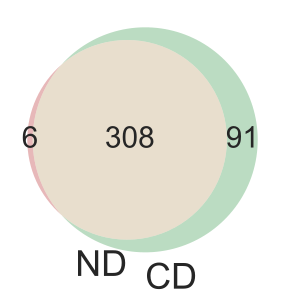

In [23]:
from matplotlib_venn import venn3
venndiagnoses = ['CON']
for i in venndiagnoses:
    display(i)
    ## first we have to select all donors that have AD or dementia in one of the three columns
    venndf = both[(both['neuropathological_diagnosis'] == i) | (both['parsed_clinical_diagnosis'] == 'other')]
    display(f"length strict: {len(venndf)}")
    nponly_s = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['parsed_clinical_diagnosis'] != 'other')]
    display(nponly_s)
    clinonly_s = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] == 'other'))]
    # display(clinonly_s)
    clinndset_s = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'] == 'other'))]
    new_both.loc[new_both['DonorID'].isin(nponly_s['DonorID']), 'clin_coherence'] = 'non_coherent'
    # new_both.loc[new_both['DonorID'].isin(clinndset_s['DonorID']), 'clin_coherence'] = 'perfect'
    # display(clinndset_s)
    print(f" jaccard strict: {len(clinndset_s)/(len(nponly_s)+len(clinonly_s)+len(clinndset_s))}")

    print(f"ND only strict {len(nponly_s)}")
    print(f"clin only strict {len(clinonly_s)}")
    print(f"clin + ND strict {len(clinndset_s)}")
    print(len(nponly_s)+len(clinonly_s)+len(clinndset_s))
    print(f" % ND {round(100*len(clinndset_s)/(len(clinndset_s)+len(nponly_s)))} ")
    print(f" % CD {round(100*len(clinndset_s)/(len(clinndset_s)+len(clinonly_s)))} ")
    venn2(subsets = (len(nponly_s), len(clinonly_s), len(clinndset_s)), set_labels = ('ND', 'CD'))
    plt.show()    
    print("\n")



'AD-DLB'

'length strict: 109'

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred
571,NBB 2003-091,AD,AD-DLB,AD
1447,NBB 2015-084,DLB,AD-DLB,AD
1534,NBB 2016-103,PD,AD-DLB,AD
1543,NBB 2016-123,AD,AD-DLB,AD
1560,NBB 2017-011,PD,AD-DLB,PD
1631,NBB 2017-131,CON,AD-DLB,AD


,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred
553,NBB 2003-065,AD-DLB,AD-DLB,AD
1725,NBB 2018-135,AD-DLB,AD-DLB,AD
1767,NBB 2019-065,AD-DLB,AD-DLB,AD


 jaccard strict: 0.027522935779816515


'length lenient: 625'

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred
10,NBB 1997-016,AD-DLB,dementia,CON
35,NBB 1997-059,AD-DLB,AD,AD
159,NBB 1998-108,AD-DLB,AD,AD
196,NBB 1998-181,AD-DLB,AD,AD
204,NBB 1999-002,AD-DLB,dementia,AD
...,...,...,...,...
1725,NBB 2018-135,AD-DLB,AD-DLB,AD
1765,NBB 2019-063,AD-DLB,DLB,AD
1767,NBB 2019-065,AD-DLB,AD-DLB,AD
1776,NBB 2019-081,AD-DLB,dementia,AD


ND only strict 100
ND only lenient 17
clin only strict 6
clin only total 522
clin + ND strict 3
clin + ND total 86
625
109
 jaccard lenient: 0.1376
 % ND 83 
 % CD 14 


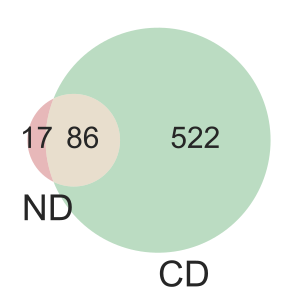

In [24]:
from matplotlib_venn import venn3
venndiagnoses = ['AD-DLB']
for i in venndiagnoses:
    display(i)
    ## first we have to select all donors that have AD or dementia in one of the three columns
    venndf = both[(both['neuropathological_diagnosis'] == i) | (both['parsed_clinical_diagnosis'] == i)]
    display(f"length strict: {len(venndf)}")
    nponly_s = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['parsed_clinical_diagnosis'] != i)]
    # display(nponly_s)
    clinonly_s = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] == i))]
    display(clinonly_s)
    clinndset_s = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'] == i))]
    display(clinndset_s)
    print(f" jaccard strict: {len(clinndset_s)/(len(nponly_s)+len(clinonly_s)+len(clinndset_s))}")

    venndf = both[(both['neuropathological_diagnosis'] == i) | (both['parsed_clinical_diagnosis'].str.contains(i))]
    venndf = both[(both['neuropathological_diagnosis'] == i) | (both['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) |\
                  (both['parsed_clinical_diagnosis'] =='dementia') |\
                  (both['parsed_clinical_diagnosis'].str.contains('AD')) |\
                  (both['parsed_clinical_diagnosis'].str.contains('DLB'))]
    # display(venndf[venndf['neuropathological_diagnosis'] != 'AD-DLB'])
    # display(venndf['parsed_clinical_diagnosis'].value_counts())
    display(f"length lenient: {len(venndf)}")
    nponly = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((~venndf['parsed_clinical_diagnosis'].str.contains(i)) & \
                         (~venndf['parsed_clinical_diagnosis'].str.contains('AD')) & \
                         (~venndf['parsed_clinical_diagnosis'].str.contains('dementia')) & \
                         (~venndf['parsed_clinical_diagnosis'].str.contains('DLB')))]
    # display(nponly)
    clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) &\
                         ((venndf['parsed_clinical_diagnosis'].str.contains(i)) |\
                          (venndf['parsed_clinical_diagnosis'].str.contains('AD')) |\
                          (venndf['parsed_clinical_diagnosis'].str.contains('dementia')) |\
                          (venndf['parsed_clinical_diagnosis'].str.contains('DLB'))
                         )]
    # display(clinonly)
    clinndset = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'].str.contains(i)) |\
                          (venndf['parsed_clinical_diagnosis'].str.contains('AD')) |\
                          (venndf['parsed_clinical_diagnosis'].str.contains('dementia')) |\
                          (venndf['parsed_clinical_diagnosis'].str.contains('DLB'))
                         )]
    display(clinndset)
    new_both.loc[new_both['DonorID'].isin(nponly['DonorID']), 'clin_coherence'] = 'non_coherent'
    # new_both.loc[new_both['DonorID'].isin(clinndset_s['DonorID']), 'clin_coherence'] = 'perfect'
    # display(clinonly['parsed_clinical_diagnosis'].value_counts())
    # x = clinonly.merge(clinonly_s[['DonorID']], on='DonorID', how='left', indicator=True)
    # display(x[x['_merge'] == 'left_only'].drop(columns=['_merge']))
    print(f"ND only strict {len(nponly_s)}")
    print(f"ND only lenient {len(nponly)}")
    print(f"clin only strict {len(clinonly_s)}")
    # print(f"clin only lenient {len(clinonly)-len(clinonly_s)}")
    print(f"clin only total {len(clinonly)}")
    print(f"clin + ND strict {len(clinndset_s)}")
    # print(f"clin + ND lenient {len(clinndset)-len(clinndset_s)}")
    print(f"clin + ND total {len(clinndset)}")
    print(len(nponly)+len(clinonly)+len(clinndset))
    print(len(nponly_s)+len(clinonly_s)+len(clinndset_s))
    print(f" jaccard lenient: {len(clinndset)/(len(nponly)+len(clinonly)+len(clinndset))}")

    print(f" % ND {round(100*len(clinndset)/(len(clinndset)+len(nponly)))} ")
    print(f" % CD {round(100*len(clinndset)/(len(clinndset)+len(clinonly)))} ")
    venn2(subsets = (len(nponly), len(clinonly), len(clinndset)), set_labels = ('ND', 'CD'))
    plt.show()
    print("\n")



In [25]:
display(new_both[100:120])
display(new_both['clin_coherence'].value_counts())
display(new_both['DonorID'].nunique())
# new_both.to_excel('/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/data/grud_clin_subset_overview_newboth.xlsx', index=False)

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred,clin_coherence
100,NBB 1998-007,AD,AD,AD,unknown/coherent
101,NBB 1998-008,MSA,MSA,PD,unknown/coherent
102,NBB 1998-009,MS,MS,MS,unknown/coherent
103,NBB 1998-011,AD,AD,AD,unknown/coherent
104,NBB 1998-015,AD,dementia,AD,unknown/coherent
105,NBB 1998-016,CON,other,CON,unknown/coherent
106,NBB 1998-019,AD-DLB,VD,AD,non_coherent
107,NBB 1998-022,AD,AD,AD,unknown/coherent
108,NBB 1998-026,AD,dementia,AD,unknown/coherent
109,NBB 1998-027,CON,other,CON,unknown/coherent


unknown/coherent    1547
non_coherent         263
Name: clin_coherence, dtype: int64

1810

In [26]:
new_both[new_both['clin_coherence']=='non_coherent']

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred,clin_coherence
11,NBB 1997-019,FTD,"DLB,AD",AD,non_coherent
18,NBB 1997-032,VD,AD,CON,non_coherent
31,NBB 1997-051,FTD,AD,AD,non_coherent
33,NBB 1997-053,VD,FTD,MS,non_coherent
40,NBB 1997-071,AD,VD,AD,non_coherent
...,...,...,...,...,...
1772,NBB 2019-074,PD,other,CON,non_coherent
1785,NBB 2019-106,PSP,other,PSP,non_coherent
1794,NBB 2019-131,MSA,PD,PD,non_coherent
1805,NBB 2020-029,PSP,FTD,FTD,non_coherent


### overview plot

In [27]:
def set_diagnosis_info(row):
    if row['pred'] == row['neuropathological_diagnosis']:
        return 'coherent'
    elif 'AD-DLB' in row['neuropathological_diagnosis']:
        if any(diagnosis in ["AD", "DLB"] for diagnosis in row['pred'].split(',')):
            return 'ambiguous'
        else:
            return 'non-coherent'
    elif all(neuropath_diagnosis in row['pred'] for neuropath_diagnosis in row['neuropathological_diagnosis']):
        return 'ambiguous'
    else:
        return 'non-coherent'
    
both['pred_info'] = both.apply(set_diagnosis_info, axis=1)
both_full['pred_info'] = both_full.apply(set_diagnosis_info, axis=1)
both['DonorID'].nunique()
display(both['pred_info'].value_counts())

coherent        1342
non-coherent     385
ambiguous         83
Name: pred_info, dtype: int64

pred_info,ambiguous,coherent,non-coherent,total_count
neuropathological_diagnosis,,,,
AD,1,426,50,477
AD-DLB,82,2,19,103
ATAXIA,0,2,17,19
CON,0,294,20,314
DLB,0,0,30,30
FTD,0,133,63,196
MND,0,3,13,16
MS,0,203,19,222
MSA,0,25,32,57


1342

385

83

1810

pred_info,ambiguous,coherent,non-coherent,total_count,coherent_percentage,non-coherent_percentage,ambiguous_percentage
neuropathological_diagnosis,,,,,,,
AD,1,426,50,477,89.308176,10.482180,0.209644
AD-DLB,82,2,19,103,1.941748,18.446602,79.611650
ATAXIA,0,2,17,19,10.526316,89.473684,0.000000
CON,0,294,20,314,93.630573,6.369427,0.000000
DLB,0,0,30,30,0.000000,100.000000,0.000000
FTD,0,133,63,196,67.857143,32.142857,0.000000
MND,0,3,13,16,18.750000,81.250000,0.000000
MS,0,203,19,222,91.441441,8.558559,0.000000
MSA,0,25,32,57,43.859649,56.140351,0.000000


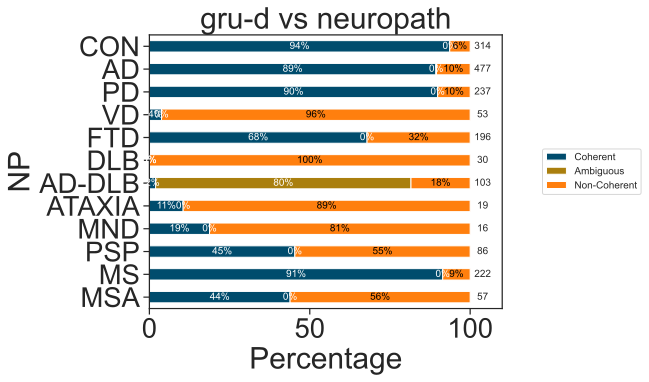

In [28]:
overview_df = both.copy()
# display(overview_df.head(9))
# grouped_df = overview_df[overview_df['neuropathological_diagnosis'] != 'CON']
grouped_df = overview_df.groupby(['neuropathological_diagnosis', 'pred_info']).size().unstack(fill_value=0)

grouped_df['total_count'] = grouped_df.sum(axis=1)
display(grouped_df)
display(grouped_df['coherent'].sum())
display(grouped_df['non-coherent'].sum())
display(grouped_df['ambiguous'].sum())
display(both['DonorID'].nunique())
# # Calculate the percentages for each category
grouped_df['coherent_percentage'] = grouped_df['coherent'] / grouped_df['total_count'] * 100
grouped_df['non-coherent_percentage'] = grouped_df['non-coherent'] / grouped_df['total_count'] * 100
grouped_df['ambiguous_percentage'] = grouped_df['ambiguous'] / grouped_df['total_count'] * 100

# Define custom colors for the plot
colors = ['#004c6d', '#aa7f0e', '#ff7f0e']
display(grouped_df)
# Define the desired order for the rows
# wanted_order = ['AD', 'PD', 'VD', 'FTD', 'DLB', 'AD-DLB', 'ATAXIA', 'MND', 'PSP', 'MS', 'MSA']
wanted_order = ['MSA', 'MS', 'PSP', 'MND','ATAXIA','AD-DLB', 'DLB', 'FTD', 'VD', 'PD', 'AD','CON']

# Reindex the DataFrame based on the desired order
grouped_df = grouped_df.reindex(wanted_order)

# Plot the stacked horizontal bar plot
ax = grouped_df[['coherent_percentage', 'ambiguous_percentage', 'non-coherent_percentage']].plot(
    kind='barh', stacked=True, figsize=(10, 6), color=colors
)

# Set labels and title
plt.xlabel('Percentage')
plt.ylabel('NP')
plt.title('gru-d vs neuropath')

# Set custom legend labels
legend_labels = ['Coherent', 'Ambiguous', 'Non-Coherent']
ax.legend(legend_labels, title='', loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=10)

for i, (idx, row) in enumerate(grouped_df.iterrows()):
    total_count = row['total_count']
    coherent_percentage = row['coherent_percentage']
    ambiguous_percentage = row['ambiguous_percentage']
    non_coherent_percentage = row['non-coherent_percentage']
    
    ax.annotate(f"{round(total_count)}", (107, i), xytext=(-10, 0), textcoords='offset points', va='center', ha='center', fontsize=10)
    ax.annotate(f"{round(coherent_percentage)}%", (coherent_percentage / 2, i), 
                va='center', ha='center', fontsize=10, color='white')
    
    ax.annotate(f"{round(ambiguous_percentage)}%", 
                (coherent_percentage + ambiguous_percentage / 2, i), 
                va='center', ha='center', fontsize=10, color='white')
    
    ax.annotate(f"{round(non_coherent_percentage)}%", 
                (coherent_percentage + ambiguous_percentage + non_coherent_percentage / 2, i), 
                va='center', ha='center', fontsize=10, color='black')
plt.xlim(0,110)

# Show the plot
plt.tight_layout()
plt.savefig('/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/figures/gru-d_overview.pdf', format='pdf', dpi=600)
plt.show()


,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred,pred_info
11,NBB 1997-019,FTD,"DLB,AD",AD,non-coherent
28,NBB 1997-046,FTD,FTD,AD,non-coherent
31,NBB 1997-051,FTD,AD,AD,non-coherent
35,NBB 1997-059,AD-DLB,AD,AD,ambiguous
62,NBB 1997-114,AD-DLB,VD,AD,ambiguous
...,...,...,...,...,...
1776,NBB 2019-081,AD-DLB,dementia,AD,ambiguous
1789,NBB 2019-123,AD-DLB,AD,AD,ambiguous
1790,NBB 2019-124,DLB,"DLB,VD",AD,non-coherent
1797,NBB 2020-008,DLB,DLB,AD,non-coherent


pred_info,ambiguous,coherent,non-coherent,total_count,coherent_percentage,non-coherent_percentage,ambiguous_percentage
pred,,,,,,,
MSA,0.0,25.0,18.0,43.0,58.139535,41.860465,0.000000
MS,0.0,203.0,37.0,240.0,84.583333,15.416667,0.000000
PSP,0.0,39.0,25.0,64.0,60.937500,39.062500,0.000000
MND,0.0,3.0,0.0,3.0,100.000000,0.000000,0.000000
ATAXIA,0.0,2.0,0.0,2.0,100.000000,0.000000,0.000000
AD-DLB,1.0,2.0,0.0,3.0,66.666667,0.000000,33.333333
DLB,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
FTD,0.0,133.0,54.0,187.0,71.122995,28.877005,0.000000
VD,0.0,2.0,1.0,3.0,66.666667,33.333333,0.000000


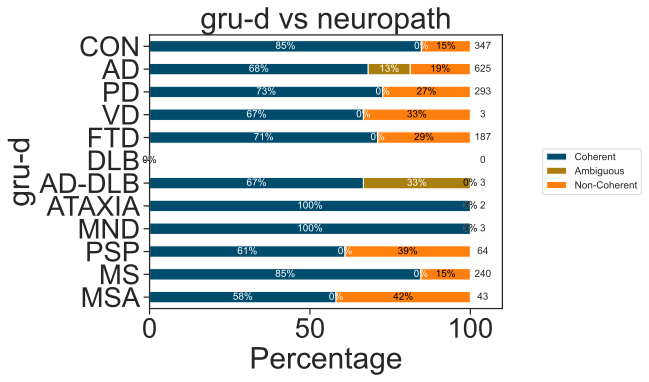

In [29]:
overview_df = both.copy()
# display(overview_df.head(9))
display(overview_df[(overview_df['pred'] == 'AD') & (overview_df['pred_info'] != 'coherent')])
grouped_df = overview_df.groupby(['pred', 'pred_info']).size().unstack(fill_value=0)

grouped_df['total_count'] = grouped_df.sum(axis=1)
# display(grouped_df)
# # Calculate the percentages for each category
grouped_df['coherent_percentage'] = grouped_df['coherent'] / grouped_df['total_count'] * 100
grouped_df['non-coherent_percentage'] = grouped_df['non-coherent'] / grouped_df['total_count'] * 100
grouped_df['ambiguous_percentage'] = grouped_df['ambiguous'] / grouped_df['total_count'] * 100

# Define custom colors for the plot
colors = ['#004c6d', '#aa7f0e', '#ff7f0e']
# display(grouped_df)
# Define the desired order for the rows
# wanted_order = ['AD', 'PD', 'VD', 'FTD', 'DLB', 'AD-DLB', 'ATAXIA', 'MND', 'PSP', 'MS', 'MSA']
wanted_order = ['MSA', 'MS', 'PSP', 'MND','ATAXIA','AD-DLB', 'DLB', 'FTD', 'VD', 'PD', 'AD','CON']

# Reindex the DataFrame based on the desired order
grouped_df = grouped_df.reindex(wanted_order)
grouped_df = grouped_df.fillna(0)
display(grouped_df)
# Plot the stacked horizontal bar plot
ax = grouped_df[['coherent_percentage', 'ambiguous_percentage', 'non-coherent_percentage']].plot(
    kind='barh', stacked=True, figsize=(10, 6), color=colors
)

# Set labels and title
plt.xlabel('Percentage')
plt.ylabel('gru-d')
plt.title('gru-d vs neuropath')

# Set custom legend labels
legend_labels = ['Coherent', 'Ambiguous', 'Non-Coherent']
ax.legend(legend_labels, title='', loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=10)

for i, (idx, row) in enumerate(grouped_df.iterrows()):
    total_count = row['total_count']
    coherent_percentage = row['coherent_percentage']
    ambiguous_percentage = row['ambiguous_percentage']
    non_coherent_percentage = row['non-coherent_percentage']
    
    ax.annotate(f"{round(total_count)}", (107, i), xytext=(-10, 0), textcoords='offset points', va='center', ha='center', fontsize=10)
    ax.annotate(f"{round(coherent_percentage)}%", (coherent_percentage / 2, i), 
                va='center', ha='center', fontsize=10, color='white')
    
    ax.annotate(f"{round(ambiguous_percentage)}%", 
                (coherent_percentage + ambiguous_percentage / 2, i), 
                va='center', ha='center', fontsize=10, color='white')
    
    ax.annotate(f"{round(non_coherent_percentage)}%", 
                (coherent_percentage + ambiguous_percentage + non_coherent_percentage / 2, i), 
                va='center', ha='center', fontsize=10, color='black')
plt.xlim(0,110)

# Show the plot
plt.tight_layout()
plt.savefig('/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/figures/gru-d_overview_fromclin.pdf', format='pdf', dpi=600)
plt.show()


### venn diagram

In [30]:
new_3venn = new_both.copy()
display(new_3venn)
new_3venn['parsed_clinical_diagnosis'].value_counts()
# display(new_3venn[(new_3venn['parsed_clinical_diagnosis'].apply(lambda x: 'MS' in x.split(','))) & (new_3venn['neuropathological_diagnosis'] != 'MS')] )
# new_3venn[(new_3venn['pred'] == 'MS') & (new_3venn['neuropathological_diagnosis'] != 'MS')] 

,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred,clin_coherence
0,NBB 1997-001,AD,AD,AD,unknown/coherent
1,NBB 1997-002,CON,other,CON,unknown/coherent
2,NBB 1997-003,AD,AD,AD,unknown/coherent
3,NBB 1997-005,CON,other,CON,unknown/coherent
4,NBB 1997-006,MS,MS,MS,unknown/coherent
...,...,...,...,...,...
1805,NBB 2020-029,PSP,FTD,FTD,non_coherent
1806,NBB 2020-030,MSA,PD,PD,non_coherent
1807,NBB 2020-052,CON,other,MS,unknown/coherent
1808,NBB 2020-054,CON,other,MS,unknown/coherent


other         399
AD            362
MS            215
PD            208
FTD           163
dementia      102
VD             51
PSP            36
MSA            34
DLB            33
AD,VD          25
PD,MSA         22
MND            19
AD,FTD         19
PD,DLB         14
PD,PSP         11
ATAXIA         10
AD-DLB          9
VD,AD           8
FTD,AD          7
MND,FTD         6
PD,AD           5
DLB,PD          4
AD,MS           3
FTD,PSP         3
FTD,MND         3
MSA,PD          3
AD,PD           3
PSP,VD          2
DLB,FTD         2
PD,FTD          2
DLB,AD          2
FTD,PD          2
PD,VD           2
PSP,FTD         2
VD,PD           1
ATAXIA,MSA      1
PD,MSA,DLB      1
MSA,PSP         1
VD,DLB          1
PD,MSA,PSP      1
PD,DLB,MSA      1
MS,MSA          1
FTD,MSA         1
PD,PSP,MSA      1
PD,AD,VD        1
VD,AD,FTD       1
VD,FTD          1
MSA,DLB         1
MND,PSP         1
DLB,MSA         1
AD,MND          1
AD,PSP          1
DLB,VD          1
Name: parsed_clinical_diagno

'PD'

'length strict cd: 261'

 jaccard strict cd: 0.7049808429118773


'length strict grud: 317'

 jaccard strict gru-d: 0.6719242902208202




'length lenient cd (in figure 3): 303'

 jaccard lenient cd (in figure 3,s7): 0.7128712871287128
ND only lenient (in figure) 21
clin + ND total (in figure) 216
clin + ND strict (in figure parentheses) 184
clin only total (in figure) 66
clin only strict (in figure parentheses) 24
 % ND 91 
 % CD 77 




'length lenient grud: 317'

 jaccard lenient grud (in figure): 0.6719242902208202




'length lenient all 3: 353'

only ND (strict) 11
only GRU-D (lenient) 50
only CD (lenient) 36
ND_CD 13
ND_GRUD 10
GRUD_CD 30
allthree 203


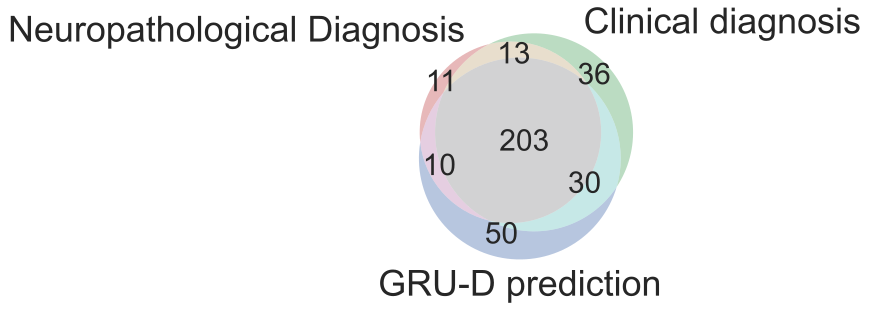

'ATAXIA'

'length strict cd: 22'

 jaccard strict cd: 0.3181818181818182


'length strict grud: 19'

 jaccard strict gru-d: 0.10526315789473684




'length lenient cd (in figure 3): 23'

 jaccard lenient cd (in figure 3,s7): 0.30434782608695654
ND only lenient (in figure) 12
clin + ND total (in figure) 7
clin + ND strict (in figure parentheses) 7
clin only total (in figure) 4
clin only strict (in figure parentheses) 3
 % ND 37 
 % CD 64 




'length lenient grud: 19'

 jaccard lenient grud (in figure): 0.10526315789473684




'length lenient all 3: 23'

only ND (strict) 12
only GRU-D (lenient) 0
only CD (lenient) 4
ND_CD 5
ND_GRUD 0
GRUD_CD 0
allthree 2


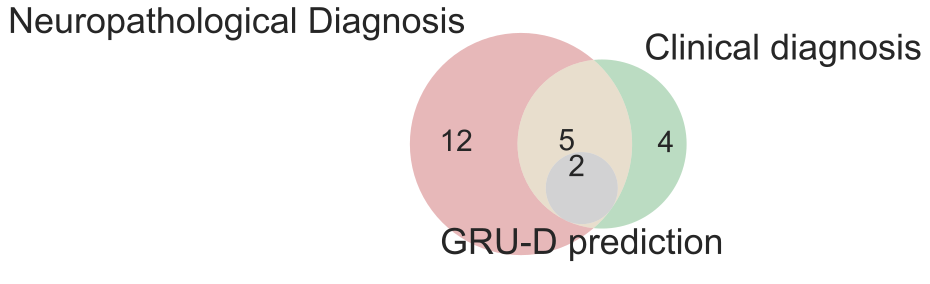

'MND'

'length strict cd: 19'

 jaccard strict cd: 0.8421052631578947


'length strict grud: 16'

 jaccard strict gru-d: 0.1875




'length lenient cd (in figure 3): 30'

 jaccard lenient cd (in figure 3,s7): 0.5333333333333333
ND only lenient (in figure) 0
clin + ND total (in figure) 16
clin + ND strict (in figure parentheses) 16
clin only total (in figure) 14
clin only strict (in figure parentheses) 3
 % ND 100 
 % CD 53 




'length lenient grud: 16'

 jaccard lenient grud (in figure): 0.1875




'length lenient all 3: 30'

only ND (strict) 0
only GRU-D (lenient) 0
only CD (lenient) 14
ND_CD 13
ND_GRUD 0
GRUD_CD 0
allthree 3


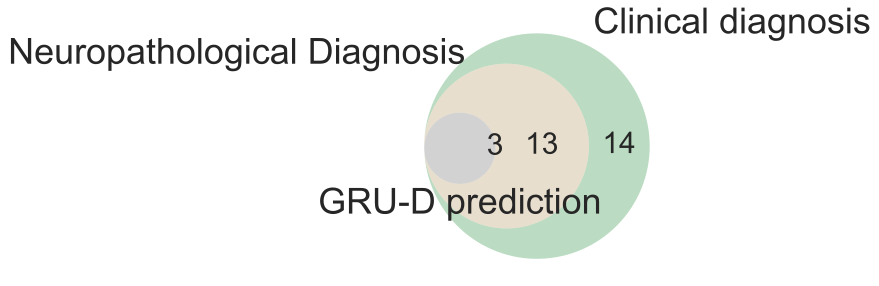

'PSP'

'length strict cd: 91'

 jaccard strict cd: 0.34065934065934067


'length strict grud: 111'

 jaccard strict gru-d: 0.35135135135135137




'length lenient cd (in figure 3): 96'

 jaccard lenient cd (in figure 3,s7): 0.5104166666666666
ND only lenient (in figure) 37
clin + ND total (in figure) 49
clin + ND strict (in figure parentheses) 31
clin only total (in figure) 10
clin only strict (in figure parentheses) 5
 % ND 57 
 % CD 83 




'length lenient grud: 111'

 jaccard lenient grud (in figure): 0.35135135135135137




'length lenient all 3: 118'

only ND (strict) 27
only GRU-D (lenient) 22
only CD (lenient) 7
ND_CD 20
ND_GRUD 10
GRUD_CD 3
allthree 29


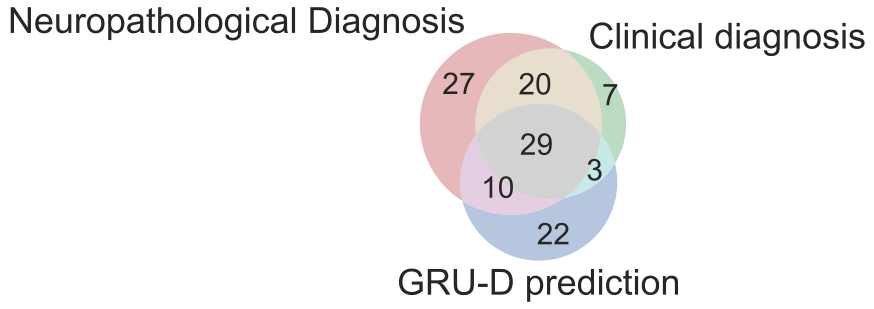

'MSA'

'length strict cd: 72'

 jaccard strict cd: 0.2638888888888889


'length strict grud: 75'

 jaccard strict gru-d: 0.3333333333333333




'length lenient cd (in figure 3): 86'

 jaccard lenient cd (in figure 3,s7): 0.46511627906976744
ND only lenient (in figure) 17
clin + ND total (in figure) 40
clin + ND strict (in figure parentheses) 19
clin only total (in figure) 29
clin only strict (in figure parentheses) 15
 % ND 70 
 % CD 58 




'length lenient grud: 75'

 jaccard lenient grud (in figure): 0.3333333333333333




'length lenient all 3: 99'

only ND (strict) 12
only GRU-D (lenient) 13
only CD (lenient) 24
ND_CD 20
ND_GRUD 5
GRUD_CD 5
allthree 20


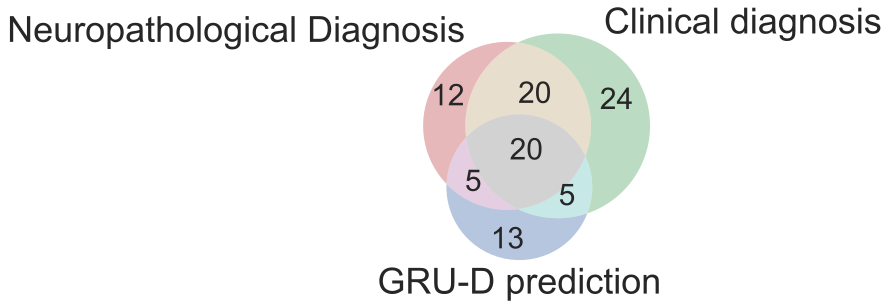

'MS'

'length strict cd: 224'

 jaccard strict cd: 0.9508928571428571


'length strict grud: 259'

 jaccard strict gru-d: 0.7837837837837838




'length lenient cd (in figure 3): 226'

 jaccard lenient cd (in figure 3,s7): 0.9513274336283186
ND only lenient (in figure) 7
clin + ND total (in figure) 215
clin + ND strict (in figure parentheses) 213
clin only total (in figure) 4
clin only strict (in figure parentheses) 2
 % ND 97 
 % CD 98 




'length lenient grud: 259'

 jaccard lenient grud (in figure): 0.7837837837837838




'length lenient all 3: 262'

only ND (strict) 2
only GRU-D (lenient) 36
only CD (lenient) 3
ND_CD 17
ND_GRUD 5
GRUD_CD 1
allthree 198


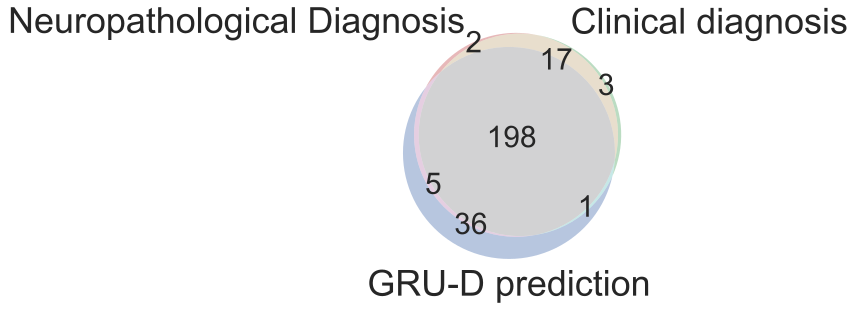

In [31]:
from matplotlib_venn import venn3
# venndiagnoses = ['MS']
venndiagnoses = ['PD','ATAXIA', 'MND', 'PSP', 'MSA','MS']
# venndiagnoses = ['MS']
for i in venndiagnoses:
    display(i)
    ## STRICT CD JACCARD
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | (new_3venn['parsed_clinical_diagnosis'] == i)]
    # display(venndf[(venndf['pred'] == 'MS') & (venndf['neuropathological_diagnosis'] != 'MS')] )
    display(f"length strict cd: {len(venndf)}")
    cd_strict_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['parsed_clinical_diagnosis'] != i)]
    cd_strict_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] == i))]
    cd_strict_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'] == i))]
    print(f" jaccard strict cd: {len(cd_strict_clinic_ND_set)/(len(cd_strict_only_ND)+len(cd_strict_only_clinic)+len(cd_strict_clinic_ND_set))}")
    
    ## STRICT GRU-D JACCARD
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | (new_3venn['pred'] == i)]
    display(f"length strict grud: {len(venndf)}")
    grud_strict_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['pred'] != i)]
    grud_strict_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['pred'] == i))]
    grud_strict_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['pred'] == i))]
    print(f" jaccard strict gru-d: {len(grud_strict_clinic_ND_set)/(len(grud_strict_only_ND)+len(grud_strict_only_clinic)+len(grud_strict_clinic_ND_set))}")
    print("\n")
    
    ##  LENIENT cd jaccard
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | new_3venn['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))]
    display(f"length lenient cd (in figure 3): {len(venndf)}")
    cd_lenient_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')))]
    cd_lenient_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')))]
    cd_lenient_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')))]
    # display(clinndset)
    print(f" jaccard lenient cd (in figure 3,s7): {len(cd_lenient_clinic_ND_set)/(len(cd_lenient_only_ND)+len(cd_lenient_only_clinic)+len(cd_lenient_clinic_ND_set))}")
    print(f"ND only lenient (in figure) {len(cd_lenient_only_ND)}")
    print(f"clin + ND total (in figure) {len(cd_lenient_clinic_ND_set)}") 
    print(f"clin + ND strict (in figure parentheses) {len(cd_strict_clinic_ND_set)}")
    print(f"clin only total (in figure) {len(cd_lenient_only_clinic)}")
    print(f"clin only strict (in figure parentheses) {len(cd_strict_only_clinic)}")

    print(f" % ND {round(100*len(cd_lenient_clinic_ND_set)/(len(cd_lenient_clinic_ND_set)+len(cd_lenient_only_ND)))} ")
    print(f" % CD {round(100*len(cd_lenient_clinic_ND_set)/(len(cd_lenient_clinic_ND_set)+len(cd_lenient_only_clinic)))} ")
    print('\n')
    ##  LENIENT grud jaccard
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | new_3venn['pred'].apply(lambda x: i in x.split(','))]
    display(f"length lenient grud: {len(venndf)}")
    grud_lenient_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    grud_lenient_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          (venndf['pred'].apply(lambda x: i in x.split(',')))]
    grud_lenient_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         (venndf['pred'].apply(lambda x: i in x.split(',')))]
    
    # display(clinndset)
    print(f" jaccard lenient grud (in figure): {len(grud_lenient_clinic_ND_set)/(len(grud_lenient_only_ND)+len(grud_lenient_only_clinic)+len(grud_lenient_clinic_ND_set))}")
    print("\n")
    
    ### SCORES WITH ALL 3
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | new_3venn['pred'].apply(lambda x: i in x.split(',')) | new_3venn['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))]
    display(f"length lenient all 3: {len(venndf)}")
    
    onlyND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    (~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) & \
                    (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    onlyGRUD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    (~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    onlyCD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) & \
                    (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    
    ND_CD = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) & \
                    (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    ND_GRUD = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    (~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    GRUD_CD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    
    allthree = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]    
    print(f"only ND (strict) {len(onlyND)}")
    print(f"only GRU-D (lenient) {len(onlyGRUD)}")
    print(f"only CD (lenient) {len(onlyCD)}")

    print(f"ND_CD {len(ND_CD)}")
    print(f"ND_GRUD {len(ND_GRUD)}")
    print(f"GRUD_CD {len(GRUD_CD)}")
    
    print(f"allthree {len(allthree)}")

    venn3(subsets=(len(onlyND), len(onlyCD),len(ND_CD), len(onlyGRUD),len(ND_GRUD), len(GRUD_CD) , len(allthree)),
        # subsets=(1, 2, 3, 4,5,6, 7),
        set_labels=('Neuropathological Diagnosis', 'Clinical diagnosis', 'GRU-D prediction'),
        normalize_to=1
    )
    plt.show()
    print("\n")



'AD'

'length strict cd: 550'

 jaccard strict cd: 0.5254545454545455


'length strict grud: 676'

 jaccard strict gru-d: 0.6301775147928994




'length lenient cd (in figure 3): 618'

 jaccard lenient cd (in figure 3,s7): 0.6456310679611651
ND only lenient (in figure) 78
clin + ND total (in figure) 399
clin + ND strict (in figure parentheses) 289
clin only total (in figure) 141
clin only strict (in figure parentheses) 73
 % ND 84 
 % CD 74 


'length lenient grud: 676'

 jaccard lenient grud (in figure): 0.6301775147928994




'length lenient all 3: 722'

only ND (strict) 22
only GRU-D (lenient) 104
only CD (lenient) 46
ND_CD 29
ND_GRUD 56
GRUD_CD 95
allthree 370


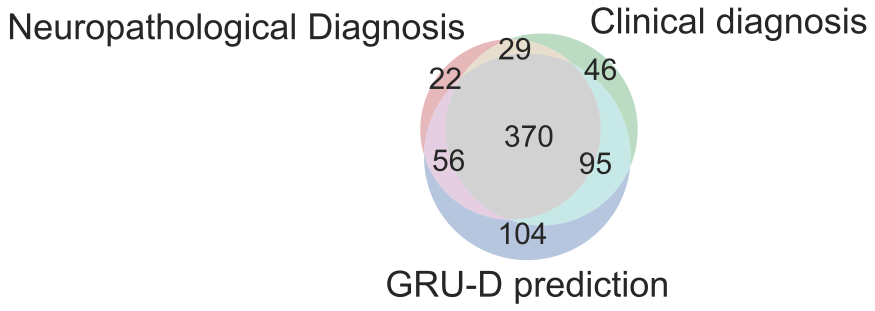

'FTD'

'length strict cd: 223'

 jaccard strict cd: 0.6098654708520179


'length strict grud: 250'

 jaccard strict gru-d: 0.532




'length lenient cd (in figure 3): 348'

 jaccard lenient cd (in figure 3,s7): 0.46551724137931033
ND only lenient (in figure) 34
clin + ND total (in figure) 162
clin + ND strict (in figure parentheses) 136
clin only total (in figure) 152
clin only strict (in figure parentheses) 27
 % ND 83 
 % CD 52 


'length lenient grud: 250'

 jaccard lenient grud (in figure): 0.532




'length lenient all 3: 387'

only ND (strict) 23
only GRU-D (lenient) 39
only CD (lenient) 137
ND_CD 40
ND_GRUD 11
GRUD_CD 15
allthree 122


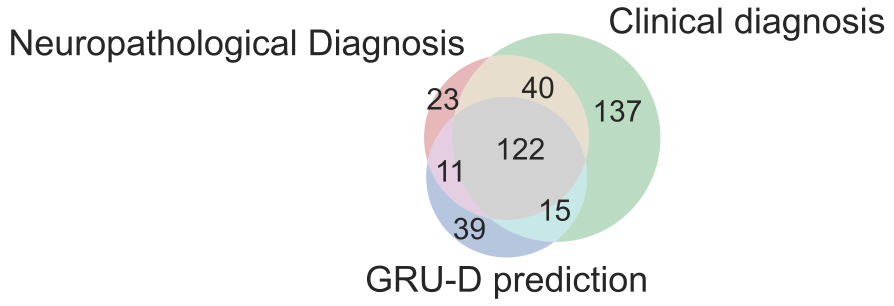

'VD'

'length strict cd: 86'

 jaccard strict cd: 0.20930232558139536


'length strict grud: 54'

 jaccard strict gru-d: 0.037037037037037035




'length lenient cd (in figure 3): 223'

 jaccard lenient cd (in figure 3,s7): 0.11659192825112108
ND only lenient (in figure) 27
clin + ND total (in figure) 26
clin + ND strict (in figure parentheses) 18
clin only total (in figure) 170
clin only strict (in figure parentheses) 33
 % ND 49 
 % CD 13 


'length lenient grud: 54'

 jaccard lenient grud (in figure): 0.037037037037037035




'length lenient all 3: 223'

only ND (strict) 27
only GRU-D (lenient) 0
only CD (lenient) 169
ND_CD 24
ND_GRUD 0
GRUD_CD 1
allthree 2


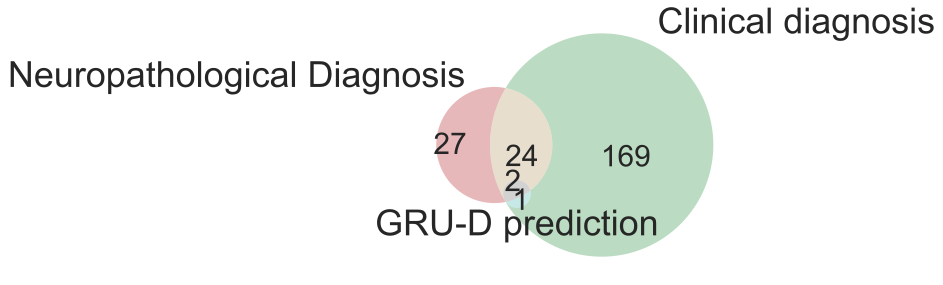

'DLB'

'length strict cd: 51'

 jaccard strict cd: 0.23529411764705882


'length strict grud: 30'

 jaccard strict gru-d: 0.0




'length lenient cd (in figure 3): 173'

 jaccard lenient cd (in figure 3,s7): 0.11560693641618497
ND only lenient (in figure) 10
clin + ND total (in figure) 20
clin + ND strict (in figure parentheses) 12
clin only total (in figure) 143
clin only strict (in figure parentheses) 21
 % ND 67 
 % CD 12 


'length lenient grud: 30'

 jaccard lenient grud (in figure): 0.0




'length lenient all 3: 173'

only ND (strict) 10
only GRU-D (lenient) 0
only CD (lenient) 143
ND_CD 20
ND_GRUD 0
GRUD_CD 0
allthree 0


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


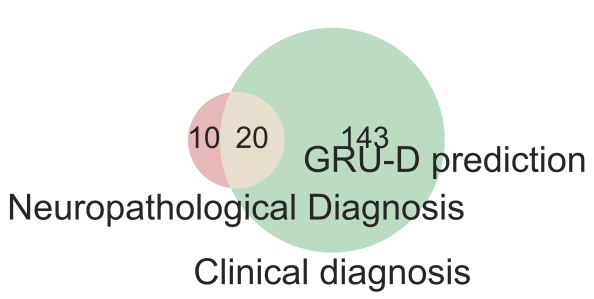

In [32]:
from matplotlib_venn import venn3
# venndiagnoses = ['MS']
venndiagnoses = ['AD','FTD','VD','DLB']
# venndiagnoses = ['DLB']
for i in venndiagnoses:
    display(i)
    ## STRICT CD JACCARD
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | (new_3venn['parsed_clinical_diagnosis'] == i)]
    # display(venndf[(venndf['pred'] == 'MS') & (venndf['neuropathological_diagnosis'] != 'MS')] )
    display(f"length strict cd: {len(venndf)}")
    cd_strict_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['parsed_clinical_diagnosis'] != i)]
    cd_strict_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] == i))]
    cd_strict_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'] == i))]
    print(f" jaccard strict cd: {len(cd_strict_clinic_ND_set)/(len(cd_strict_only_ND)+len(cd_strict_only_clinic)+len(cd_strict_clinic_ND_set))}")
    
    ## STRICT GRU-D JACCARD
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | (new_3venn['pred'] == i)]
    display(f"length strict grud: {len(venndf)}")
    grud_strict_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['pred'] != i)]
    grud_strict_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['pred'] == i))]
    grud_strict_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['pred'] == i))]
    print(f" jaccard strict gru-d: {len(grud_strict_clinic_ND_set)/(len(grud_strict_only_ND)+len(grud_strict_only_clinic)+len(grud_strict_clinic_ND_set))}")
    print("\n")
    
    ##  LENIENT cd jaccard
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | new_3venn['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')) | new_3venn['parsed_clinical_diagnosis'].apply(lambda x: 'dementia' in x.split(','))]
    display(f"length lenient cd (in figure 3): {len(venndf)}")
    cd_lenient_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                                ((venndf['parsed_clinical_diagnosis'] != 'dementia') & \
                                (~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))))]
    cd_lenient_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                                    ((venndf['parsed_clinical_diagnosis'] == 'dementia') | \
                                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))))]
    cd_lenient_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                                      ((venndf['parsed_clinical_diagnosis'] == 'dementia') | \
                                       (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))))]
    # display(cd_lenient_clinic_ND_set)
    print(f" jaccard lenient cd (in figure 3,s7): {len(cd_lenient_clinic_ND_set)/(len(cd_lenient_only_ND)+len(cd_lenient_only_clinic)+len(cd_lenient_clinic_ND_set))}")
    print(f"ND only lenient (in figure) {len(cd_lenient_only_ND)}")
    print(f"clin + ND total (in figure) {len(cd_lenient_clinic_ND_set)}") 
    print(f"clin + ND strict (in figure parentheses) {len(cd_strict_clinic_ND_set)}")
    print(f"clin only total (in figure) {len(cd_lenient_only_clinic)}")
    print(f"clin only strict (in figure parentheses) {len(cd_strict_only_clinic)}")

    print(f" % ND {round(100*len(cd_lenient_clinic_ND_set)/(len(cd_lenient_clinic_ND_set)+len(cd_lenient_only_ND)))} ")
    print(f" % CD {round(100*len(cd_lenient_clinic_ND_set)/(len(cd_lenient_clinic_ND_set)+len(cd_lenient_only_clinic)))} ")
    
    ##  LENIENT grud jaccard
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | new_3venn['pred'].apply(lambda x: i in x.split(','))]
    display(f"length lenient grud: {len(venndf)}")
    grud_lenient_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    grud_lenient_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          (venndf['pred'].apply(lambda x: i in x.split(',')))]
    grud_lenient_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         (venndf['pred'].apply(lambda x: i in x.split(',')))]
    # display(clinndset)
    print(f" jaccard lenient grud (in figure): {len(grud_lenient_clinic_ND_set)/(len(grud_lenient_only_ND)+len(grud_lenient_only_clinic)+len(grud_lenient_clinic_ND_set))}")
    print("\n")
    
    ### SCORES WITH ALL 3
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | new_3venn['pred'].apply(lambda x: i in x.split(',')) | new_3venn['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')) | new_3venn['parsed_clinical_diagnosis'].apply(lambda x: 'dementia' in x.split(',') )]
    display(f"length lenient all 3: {len(venndf)}")
    
    onlyND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    ((~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) &  (venndf['parsed_clinical_diagnosis'] != 'dementia') ) & \
                    (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    onlyGRUD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    ((~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) &  (venndf['parsed_clinical_diagnosis'] != 'dementia') ) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    onlyCD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    ( (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) | (venndf['parsed_clinical_diagnosis'] == 'dementia')) & \
                    (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    
    ND_CD = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    ( (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) | (venndf['parsed_clinical_diagnosis'] == 'dementia')) & \
                    (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    ND_GRUD = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    ((~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) &  (venndf['parsed_clinical_diagnosis'] != 'dementia') ) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    GRUD_CD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    ( (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) | (venndf['parsed_clinical_diagnosis'] == 'dementia')) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    
    allthree = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    ( (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) | (venndf['parsed_clinical_diagnosis'] == 'dementia')) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]    
    print(f"only ND (strict) {len(onlyND)}")
    print(f"only GRU-D (lenient) {len(onlyGRUD)}")
    print(f"only CD (lenient) {len(onlyCD)}")
    # display(onlyCD)
    print(f"ND_CD {len(ND_CD)}")
    print(f"ND_GRUD {len(ND_GRUD)}")
    print(f"GRUD_CD {len(GRUD_CD)}")
    
    print(f"allthree {len(allthree)}")

    venn3(subsets=(len(onlyND), len(onlyCD),len(ND_CD), len(onlyGRUD),len(ND_GRUD), len(GRUD_CD) , len(allthree)),
        # subsets=(1, 2, 3, 4,5,6, 7),
        set_labels=('Neuropathological Diagnosis', 'Clinical diagnosis', 'GRU-D prediction'),
        normalize_to=1
    )
    plt.show()
    print("\n")



'CON'

'length strict cd: 405'

 jaccard strict cd: 0.7604938271604939


'length strict grud: 367'

 jaccard strict gru-d: 0.8010899182561307




'length lenient cd (in figure 3): 405'

 jaccard lenient cd (in figure 3,s7): 0.7604938271604939
ND only lenient (in figure) 6
clin + ND total (in figure) 308
clin + ND strict (in figure parentheses) 308
clin only total (in figure) 91
clin only strict (in figure parentheses) 91
 % ND 98 
 % CD 77 


'length lenient grud: 367'

 jaccard lenient grud (in figure): 0.8010899182561307




'length lenient all 3: 447'

only ND (strict) 2
only GRU-D (lenient) 42
only CD (lenient) 80
ND_CD 18
ND_GRUD 4
GRUD_CD 11
allthree 290


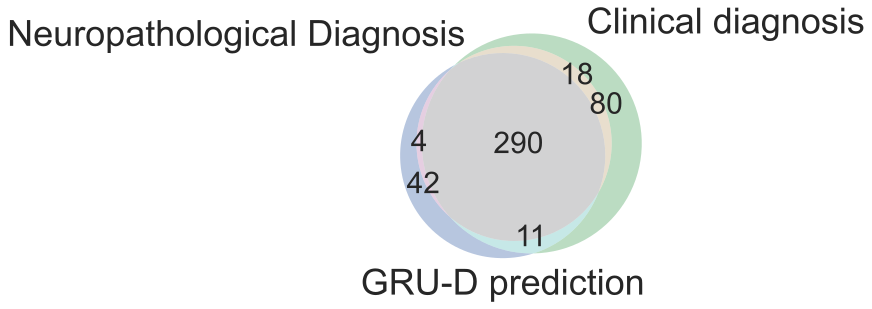

In [33]:
from matplotlib_venn import venn3
# venndiagnoses = ['MS']
venndiagnoses = ['CON']
# venndiagnoses = ['MS']
for i in venndiagnoses:
    display(i)
    ## STRICT CD JACCARD
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | (new_3venn['parsed_clinical_diagnosis'] == 'other')]
    # display(venndf[(venndf['pred'] == 'MS') & (venndf['neuropathological_diagnosis'] != 'MS')] )
    display(f"length strict cd: {len(venndf)}")
    cd_strict_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['parsed_clinical_diagnosis'] != 'other')]
    cd_strict_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] == 'other'))]
    cd_strict_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'] == 'other'))]
    print(f" jaccard strict cd: {len(cd_strict_clinic_ND_set)/(len(cd_strict_only_ND)+len(cd_strict_only_clinic)+len(cd_strict_clinic_ND_set))}")
    
    ## STRICT GRU-D JACCARD
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | (new_3venn['pred'] == i)]
    display(f"length strict grud: {len(venndf)}")
    grud_strict_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['pred'] != i)]
    grud_strict_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['pred'] == i))]
    grud_strict_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['pred'] == i))]
    print(f" jaccard strict gru-d: {len(grud_strict_clinic_ND_set)/(len(grud_strict_only_ND)+len(grud_strict_only_clinic)+len(grud_strict_clinic_ND_set))}")
    print("\n")
    
    ##  LENIENT cd jaccard
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | new_3venn['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(','))]
    display(f"length lenient cd (in figure 3): {len(venndf)}")
    cd_lenient_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (~venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(',')))]
    cd_lenient_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(',')))]
    cd_lenient_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(',')))]
    # display(clinndset)
    print(f" jaccard lenient cd (in figure 3,s7): {len(cd_lenient_clinic_ND_set)/(len(cd_lenient_only_ND)+len(cd_lenient_only_clinic)+len(cd_lenient_clinic_ND_set))}")
    print(f"ND only lenient (in figure) {len(cd_lenient_only_ND)}")
    print(f"clin + ND total (in figure) {len(cd_lenient_clinic_ND_set)}") 
    print(f"clin + ND strict (in figure parentheses) {len(cd_strict_clinic_ND_set)}")
    print(f"clin only total (in figure) {len(cd_lenient_only_clinic)}")
    print(f"clin only strict (in figure parentheses) {len(cd_strict_only_clinic)}")

    print(f" % ND {round(100*len(cd_lenient_clinic_ND_set)/(len(cd_lenient_clinic_ND_set)+len(cd_lenient_only_ND)))} ")
    print(f" % CD {round(100*len(cd_lenient_clinic_ND_set)/(len(cd_lenient_clinic_ND_set)+len(cd_lenient_only_clinic)))} ")
    
    ##  LENIENT grud jaccard
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | new_3venn['pred'].apply(lambda x: i in x.split(','))]
    display(f"length lenient grud: {len(venndf)}")
    grud_lenient_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    grud_lenient_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          (venndf['pred'].apply(lambda x: i in x.split(',')))]
    grud_lenient_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         (venndf['pred'].apply(lambda x: i in x.split(',')))]
    # display(clinndset)
    print(f" jaccard lenient grud (in figure): {len(grud_lenient_clinic_ND_set)/(len(grud_lenient_only_ND)+len(grud_lenient_only_clinic)+len(grud_lenient_clinic_ND_set))}")
    print("\n")
    
    ### SCORES WITH ALL 3
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | new_3venn['pred'].apply(lambda x: i in x.split(',')) | new_3venn['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(','))]
    display(f"length lenient all 3: {len(venndf)}")
    
    onlyND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    (~venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(','))) & \
                    (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    onlyGRUD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    (~venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(','))) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    onlyCD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(','))) & \
                    (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    
    ND_CD = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(','))) & \
                    (~venndf['pred'].apply(lambda x: i in x.split(',')))]
    ND_GRUD = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    (~venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(','))) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    GRUD_CD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(','))) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    
    allthree = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'other' in x.split(','))) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]    
    
    print(f"only ND (strict) {len(onlyND)}")
    print(f"only GRU-D (lenient) {len(onlyGRUD)}")
    print(f"only CD (lenient) {len(onlyCD)}")

    print(f"ND_CD {len(ND_CD)}")
    print(f"ND_GRUD {len(ND_GRUD)}")
    print(f"GRUD_CD {len(GRUD_CD)}")
    
    print(f"allthree {len(allthree)}")

    venn3(subsets=(len(onlyND), len(onlyCD),len(ND_CD), len(onlyGRUD),len(ND_GRUD), len(GRUD_CD) , len(allthree)),
        # subsets=(1, 2, 3, 4,5,6, 7),
        set_labels=('Neuropathological Diagnosis', 'Clinical diagnosis', 'GRU-D prediction'),
        normalize_to=1
    )
    plt.show()
    print("\n")



'AD-DLB'

'length strict cd: 109'

 jaccard strict cd: 0.027522935779816515


'length strict grud: 104'

 jaccard strict gru-d: 0.019230769230769232




'length lenient cd (in figure 3): 625'

 jaccard lenient cd (in figure 3,s7): 0.1376
ND only lenient (in figure) 17
clin + ND total (in figure) 86
clin + ND strict (in figure parentheses) 3
clin only total (in figure) 522
clin only strict (in figure parentheses) 6
 % ND 83 
 % CD 14 


'length lenient grud: 647'

 jaccard lenient grud (in figure): 0.12982998454404945




'length lenient all 3: 196'

only ND (strict) 18
only GRU-D (lenient) 1
only CD (lenient) 21


,DonorID,neuropathological_diagnosis,parsed_clinical_diagnosis,pred,clin_coherence
7,NBB 1997-012,AD,dementia,CON,unknown/coherent
19,NBB 1997-033,AD,dementia,FTD,unknown/coherent
70,NBB 1997-125,AD,dementia,PD,unknown/coherent
83,NBB 1997-146,CON,dementia,CON,non_coherent
257,NBB 1999-105,AD,dementia,PD,unknown/coherent
314,NBB 2000-069,AD,dementia,CON,unknown/coherent
509,NBB 2003-001,AD,dementia,FTD,unknown/coherent
588,NBB 2004-009,VD,dementia,VD,unknown/coherent
701,NBB 2005-073,CON,dementia,CON,non_coherent
719,NBB 2006-010,AD,dementia,CON,unknown/coherent


ND_CD 1
ND_GRUD 2
GRUD_CD 0
allthree 0


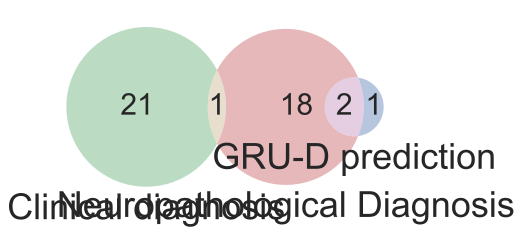

In [34]:
from matplotlib_venn import venn3
# venndiagnoses = ['MS']
venndiagnoses = ['AD','FTD','VD','DLB']
venndiagnoses = ['AD-DLB']
for i in venndiagnoses:
    display(i)
    ## STRICT CD JACCARD
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | (new_3venn['parsed_clinical_diagnosis'] == i)]
    # display(venndf[(venndf['pred'] == 'MS') & (venndf['neuropathological_diagnosis'] != 'MS')] )
    display(f"length strict cd: {len(venndf)}")
    cd_strict_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['parsed_clinical_diagnosis'] != i)]
    cd_strict_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] == i))]
    cd_strict_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'] == i))]
    print(f" jaccard strict cd: {len(cd_strict_clinic_ND_set)/(len(cd_strict_only_ND)+len(cd_strict_only_clinic)+len(cd_strict_clinic_ND_set))}")
    
    ## STRICT GRU-D JACCARD
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) | (new_3venn['pred'] == i)]
    display(f"length strict grud: {len(venndf)}")
    grud_strict_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        (venndf['pred'] != i)]
    grud_strict_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['pred'] == i))]
    grud_strict_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['pred'] == i))]
    print(f" jaccard strict gru-d: {len(grud_strict_clinic_ND_set)/(len(grud_strict_only_ND)+len(grud_strict_only_clinic)+len(grud_strict_clinic_ND_set))}")
    print("\n")
    
    ##  LENIENT cd jaccard
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) |\
                       new_3venn['parsed_clinical_diagnosis'].apply(lambda x: 'AD' in x.split(',')) |\
                       new_3venn['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')) |\
                       new_3venn['parsed_clinical_diagnosis'].apply(lambda x: 'DLB' in x.split(',')) |\
                       new_3venn['parsed_clinical_diagnosis'].apply(lambda x: 'dementia' in x.split(','))]
    display(f"length lenient cd (in figure 3): {len(venndf)}")
    cd_lenient_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                                ((venndf['parsed_clinical_diagnosis'] != 'dementia') & \
                                 (~venndf['parsed_clinical_diagnosis'].apply(lambda x: 'DLB' in x.split(','))) &\
                                 (~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) &\
                                (~venndf['parsed_clinical_diagnosis'].apply(lambda x: 'AD' in x.split(','))))]
    cd_lenient_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                                    ((venndf['parsed_clinical_diagnosis'] == 'dementia') | \
                                     (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'DLB' in x.split(','))) |\
                                     (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) |\
                                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'AD' in x.split(','))))]
    cd_lenient_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                                      ((venndf['parsed_clinical_diagnosis'] == 'dementia') | \
                                     (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'DLB' in x.split(','))) |\
                                     (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) |\
                                    (venndf['parsed_clinical_diagnosis'].apply(lambda x: 'AD' in x.split(','))))]
    # display(cd_lenient_clinic_ND_set)
    print(f" jaccard lenient cd (in figure 3,s7): {len(cd_lenient_clinic_ND_set)/(len(cd_lenient_only_ND)+len(cd_lenient_only_clinic)+len(cd_lenient_clinic_ND_set))}")
    print(f"ND only lenient (in figure) {len(cd_lenient_only_ND)}")
    print(f"clin + ND total (in figure) {len(cd_lenient_clinic_ND_set)}") 
    print(f"clin + ND strict (in figure parentheses) {len(cd_strict_clinic_ND_set)}")
    print(f"clin only total (in figure) {len(cd_lenient_only_clinic)}")
    print(f"clin only strict (in figure parentheses) {len(cd_strict_only_clinic)}")

    print(f" % ND {round(100*len(cd_lenient_clinic_ND_set)/(len(cd_lenient_clinic_ND_set)+len(cd_lenient_only_ND)))} ")
    print(f" % CD {round(100*len(cd_lenient_clinic_ND_set)/(len(cd_lenient_clinic_ND_set)+len(cd_lenient_only_clinic)))} ")
    
    ##  LENIENT grud jaccard
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) |\
                       new_3venn['pred'].apply(lambda x: 'AD' in x.split(',')) |\
                       new_3venn['pred'].apply(lambda x: 'DLB' in x.split(',')) |\
                       new_3venn['pred'].apply(lambda x: i in x.split(','))]
    display(f"length lenient grud: {len(venndf)}")
    grud_lenient_only_ND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((~venndf['pred'].apply(lambda x: i in x.split(','))) & (~venndf['pred'].apply(lambda x: 'AD' in x.split(','))) & (~venndf['pred'].apply(lambda x: 'DLB' in x.split(','))) )]
    grud_lenient_only_clinic = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['pred'].apply(lambda x: i in x.split(','))) | (venndf['pred'].apply(lambda x: 'AD' in x.split(','))) | (venndf['pred'].apply(lambda x: 'DLB' in x.split(','))) )]
    grud_lenient_clinic_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['pred'].apply(lambda x: i in x.split(','))) | (venndf['pred'].apply(lambda x: 'AD' in x.split(','))) | (venndf['pred'].apply(lambda x: 'DLB' in x.split(','))) )]
    # display(clinndset)
    print(f" jaccard lenient grud (in figure): {len(grud_lenient_clinic_ND_set)/(len(grud_lenient_only_ND)+len(grud_lenient_only_clinic)+len(grud_lenient_clinic_ND_set))}")
    print("\n")
    
    ### SCORES WITH ALL 3
    venndf = new_3venn[(new_3venn['neuropathological_diagnosis'] == i) |\
                       new_3venn['pred'].apply(lambda x: i in x.split(',')) |\
                       new_3venn['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(',')) |\
                       new_3venn['parsed_clinical_diagnosis'].apply(lambda x: 'dementia' in x.split(',') )]
    display(f"length lenient all 3: {len(venndf)}")
    
    onlyND = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    ((~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) &  (venndf['parsed_clinical_diagnosis'] != 'dementia') ) & \
                    ((~venndf['pred'].apply(lambda x: i in x.split(','))) & (~venndf['pred'].apply(lambda x: 'AD' in x.split(','))) & (~venndf['pred'].apply(lambda x: 'DLB' in x.split(','))) )]
    onlyGRUD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    ((~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) &  (venndf['parsed_clinical_diagnosis'] != 'dementia') ) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    onlyCD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    ( (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) | (venndf['parsed_clinical_diagnosis'] == 'dementia')) & \
                    ((~venndf['pred'].apply(lambda x: i in x.split(','))) & (~venndf['pred'].apply(lambda x: 'AD' in x.split(','))) & (~venndf['pred'].apply(lambda x: 'DLB' in x.split(','))) )]
    
    ND_CD = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    ( (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) | (venndf['parsed_clinical_diagnosis'] == 'dementia')) & \
                    ((~venndf['pred'].apply(lambda x: i in x.split(','))) & (~venndf['pred'].apply(lambda x: 'AD' in x.split(','))) & (~venndf['pred'].apply(lambda x: 'DLB' in x.split(','))) )]
    ND_GRUD = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    ((~venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) &  (venndf['parsed_clinical_diagnosis'] != 'dementia') ) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    GRUD_CD = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                    ( (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) | (venndf['parsed_clinical_diagnosis'] == 'dementia')) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]
    
    allthree = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                    ( (venndf['parsed_clinical_diagnosis'].apply(lambda x: i in x.split(','))) | (venndf['parsed_clinical_diagnosis'] == 'dementia')) & \
                    (venndf['pred'].apply(lambda x: i in x.split(',')))]    
    print(f"only ND (strict) {len(onlyND)}")
    print(f"only GRU-D (lenient) {len(onlyGRUD)}")
    print(f"only CD (lenient) {len(onlyCD)}")
    display(onlyCD)
    print(f"ND_CD {len(ND_CD)}")
    print(f"ND_GRUD {len(ND_GRUD)}")
    print(f"GRUD_CD {len(GRUD_CD)}")
    
    print(f"allthree {len(allthree)}")

    venn3(subsets=(len(onlyND), len(onlyCD),len(ND_CD), len(onlyGRUD),len(ND_GRUD), len(GRUD_CD) , len(allthree)),
        # subsets=(1, 2, 3, 4,5,6, 7),
        set_labels=('Neuropathological Diagnosis', 'Clinical diagnosis', 'GRU-D prediction'),
        normalize_to=1
    )
    plt.show()
    print("\n")



#### OLD

728

ND only 22
pred only 103
clin only 51
clin+pred 97
clin + ND 30
pred+ND 54
all three 371
728


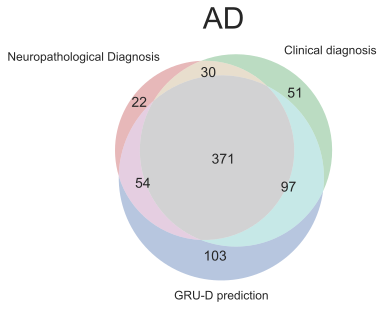

386

ND only 22
pred only 39
clin only 136
clin+pred 15
clin + ND 46
pred+ND 12
all three 116
386


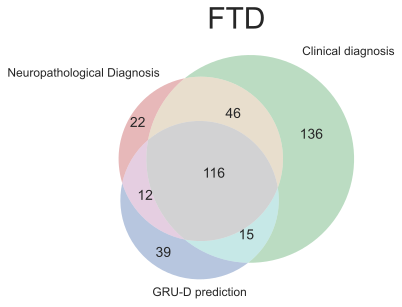

224

ND only 25
pred only 1
clin only 169
clin+pred 1
clin + ND 26
pred+ND 2
all three 0
224


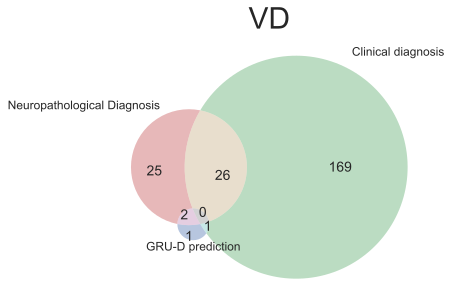

182

ND only 9
pred only 0
clin only 151
clin+pred 0
clin + ND 20
pred+ND 0
all three 0
180


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


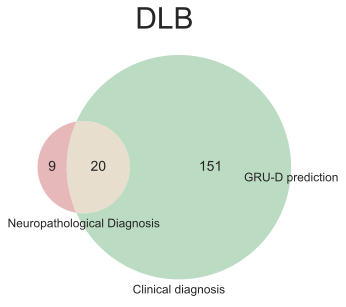

In [21]:
from matplotlib_venn import venn3
venndiagnoses = ['AD','FTD','VD','DLB']
# venndiagnoses = ['AD']
for i in venndiagnoses:
    ## first we have to select all donors that have AD or dementia in one of the three columns
    venndf = both[(both['neuropathological_diagnosis'] ==i) | (both['parsed_clinical_diagnosis'].str.contains(i)) | \
                  (both['pred'].str.contains(i)) | (both['parsed_clinical_diagnosis'] =='dementia') ]
    # venndf = venndf[['DonorID','neuropathological_diagnosis','parsed_clinical_diagnosis','pred']].copy()
    # display(venndf)
    display(len(venndf))
    nponly = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((~venndf['parsed_clinical_diagnosis'].str.contains(i)) & (venndf['parsed_clinical_diagnosis']!='dementia')) & \
                        (venndf['pred'] != i)]
    predonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((~venndf['parsed_clinical_diagnosis'].str.contains(i)) & (venndf['parsed_clinical_diagnosis']!='dementia')) & \
                          (venndf['pred'] == i)]
    clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | (venndf['parsed_clinical_diagnosis']=='dementia')) & \
                          (venndf['pred'] != i)]
    notnp = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                       ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | (venndf['parsed_clinical_diagnosis']=='dementia')) & \
                       (venndf['pred'] == i)]
    notpred = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | (venndf['parsed_clinical_diagnosis']=='dementia')) &\
                         (~venndf['pred'].str.contains(i))]
    notclin =venndf[(venndf['neuropathological_diagnosis'] == i) & \
                         ((~venndf['parsed_clinical_diagnosis'].str.contains(i)) & (venndf['parsed_clinical_diagnosis']!='dementia')) & \
                         (venndf['pred'] == i)]
    allthree = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                          ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | (venndf['parsed_clinical_diagnosis']=='dementia')) &\
                           (venndf['pred'].str.contains(i) )]
    # common_elements = list(set(list(allthree['DonorID'])).intersection(list(notpred['DonorID'])))
    # print(common_elements)
    print(f"ND only {len(nponly)}")
    print(f"pred only {len(predonly)}")
    print(f"clin only {len(clinonly)}")
    print(f"clin+pred {len(notnp)}")
    print(f"clin + ND {len(notpred)}")
    print(f"pred+ND {len(notclin)}")
    print(f"all three {len(allthree)}")
    print(len(nponly)+len(predonly)+len(clinonly)+len(notnp)+len(notpred)+len(notclin)+len(allthree))
    venn = venn3(
        subsets=(len(nponly), len(clinonly),len(notpred), len(predonly),len(notclin), len(notnp) , len(allthree)),
        # subsets=(1, 2, 3, 4,5,6, 7),
        set_labels=('Neuropathological Diagnosis', 'Clinical diagnosis', 'GRU-D prediction'),
        normalize_to=1
    )
    for text in venn.set_labels:
        text.set_fontsize(12)
    for text in venn.subset_labels:
        if text is not None:
            text.set_fontsize(14)
    plt.title(i)
    plt.show()


,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
7,NBB 1997-012,AD,1997,dementia,ambiguous,CON,non-coherent
10,NBB 1997-016,AD-DLB,1997,dementia,ambiguous,CON,non-coherent
19,NBB 1997-033,AD,1997,dementia,ambiguous,FTD,non-coherent
35,NBB 1997-059,AD-DLB,1997,AD,ambiguous,AD,ambiguous
59,NBB 1997-110,AD,1997,dementia,ambiguous,AD,coherent
...,...,...,...,...,...,...,...
1722,NBB 2018-135,AD-DLB,2018,AD-DLB,coherent,AD,ambiguous
1762,NBB 2019-063,AD-DLB,2019,DLB,ambiguous,AD,ambiguous
1764,NBB 2019-065,AD-DLB,2019,AD-DLB,coherent,AD,ambiguous
1773,NBB 2019-081,AD-DLB,2019,dementia,ambiguous,AD,ambiguous


196

,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
59,NBB 1997-110,AD,1997,dementia,ambiguous,AD,coherent
75,NBB 1997-133,AD,1997,dementia,ambiguous,AD,coherent
93,NBB 1997-167,AD,1997,dementia,ambiguous,AD,coherent
103,NBB 1998-015,AD,1998,dementia,ambiguous,AD,coherent
107,NBB 1998-026,AD,1998,dementia,ambiguous,AD,coherent
...,...,...,...,...,...,...,...
1541,NBB 2016-123,AD,2016,AD-DLB,ambiguous,AD,coherent
1618,NBB 2017-116,AD,2017,dementia,ambiguous,AD,coherent
1628,NBB 2017-131,CON,2017,AD-DLB,non-coherent,AD,non-coherent
1658,NBB 2018-020,AD,2018,dementia,ambiguous,AD,coherent


ND only 4
pred only 1
clin only 21
clin+pred 72
clin + ND 15
pred+ND 13
all three 71
197


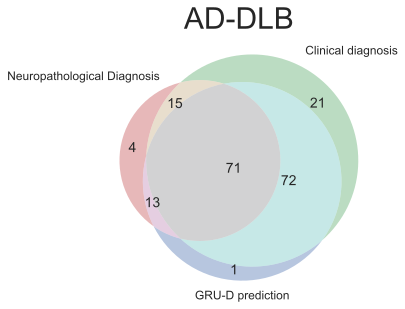

In [22]:
from matplotlib_venn import venn3
venndiagnoses = ['AD-DLB']
# venndiagnoses = ['AD']
for i in venndiagnoses:
    ## first we have to select all donors that have AD or dementia in one of the three columns
    venndf = both[(both['neuropathological_diagnosis'] ==i) | (both['parsed_clinical_diagnosis'].str.contains(i)) | \
                  (both['pred'].str.contains(i)) | (both['parsed_clinical_diagnosis'] =='dementia') ]
    # venndf = venndf[['DonorID','neuropathological_diagnosis','parsed_clinical_diagnosis','pred']].copy()
    display(venndf)
    display(len(venndf))
    nponly = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((~venndf['parsed_clinical_diagnosis'].str.contains(i)) &\
                         (~venndf['parsed_clinical_diagnosis'].str.contains('AD')) & \
                         (~venndf['parsed_clinical_diagnosis'].str.contains('DLB'))& \
                         (venndf['parsed_clinical_diagnosis']!='dementia')) & \
                        ((venndf['pred'] != i)&(venndf['pred'] != 'AD')&(venndf['pred'] != 'DLB'))]
    predonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((~venndf['parsed_clinical_diagnosis'].str.contains(i)) & (venndf['parsed_clinical_diagnosis']!='dementia')) & \
                          (venndf['pred'] == i)]
    clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | (venndf['parsed_clinical_diagnosis']=='dementia')) & \
                          ((venndf['pred'] != i)&(venndf['pred'] != 'AD')&(venndf['pred'] != 'DLB'))]
    notnp = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                       ((venndf['parsed_clinical_diagnosis'].str.contains(i)) |\
                        (venndf['parsed_clinical_diagnosis'].str.contains('AD')) |\
                        (venndf['parsed_clinical_diagnosis'].str.contains('DLB')) |\
                        (venndf['parsed_clinical_diagnosis']=='dementia')) & \
                       ((venndf['pred'] == i) | (venndf['pred'] == 'AD') | (venndf['pred'] == 'DLB'))]
    notpred = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'].str.contains(i)) |\
                          (venndf['parsed_clinical_diagnosis'].str.contains('AD')) |\
                          (venndf['parsed_clinical_diagnosis'].str.contains('DLB')) |\
                          (venndf['parsed_clinical_diagnosis']=='dementia')) &\
                         ((venndf['pred'] != i)&(venndf['pred'] != 'AD')&(venndf['pred'] != 'DLB'))]
    notclin =venndf[(venndf['neuropathological_diagnosis'] == i) & \
                         ((~venndf['parsed_clinical_diagnosis'].str.contains(i)) & \
                          (~venndf['parsed_clinical_diagnosis'].str.contains('AD')) & \
                          (~venndf['parsed_clinical_diagnosis'].str.contains('DLB')) & \
                          (venndf['parsed_clinical_diagnosis']!='dementia')) & \
                         ((venndf['pred'] == i) | (venndf['pred'] == 'AD') | (venndf['pred'] == 'DLB'))]
    allthree = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                          ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | \
                           (venndf['parsed_clinical_diagnosis'].str.contains('AD')) | \
                           (venndf['parsed_clinical_diagnosis'].str.contains('DLB')) | \
                           (venndf['parsed_clinical_diagnosis']=='dementia')) &\
                           ((venndf['pred'] == i) | (venndf['pred'] == 'AD') | (venndf['pred'] == 'DLB'))]
    # common_elements = list(set(list(allthree['DonorID'])).intersection(list(notpred['DonorID'])))
    # print(common_elements)
    display(notnp)
    print(f"ND only {len(nponly)}")
    print(f"pred only {len(predonly)}")
    print(f"clin only {len(clinonly)}")
    print(f"clin+pred {len(notnp)}")
    print(f"clin + ND {len(notpred)}")
    print(f"pred+ND {len(notclin)}")
    print(f"all three {len(allthree)}")
    print(len(nponly)+len(predonly)+len(clinonly)+len(notnp)+len(notpred)+len(notclin)+len(allthree))
    venn = venn3(
        subsets=(len(nponly), len(clinonly),len(notpred), len(predonly),len(notclin), len(notnp) , len(allthree)),
        # subsets=(1, 2, 3, 4,5,6, 7),
        set_labels=('Neuropathological Diagnosis', 'Clinical diagnosis', 'GRU-D prediction'),
        normalize_to=1
    )
    for text in venn.set_labels:
        text.set_fontsize(12)
    for text in venn.subset_labels:
        if text is not None:
            text.set_fontsize(14)
    plt.title(i)
    plt.show()


445

,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
1,NBB 1997-002,CON,1997,other,coherent,CON,coherent
3,NBB 1997-005,CON,1997,other,coherent,CON,coherent
5,NBB 1997-008,CON,1997,other,coherent,CON,coherent
7,NBB 1997-012,AD,1997,dementia,ambiguous,CON,non-coherent
10,NBB 1997-016,AD-DLB,1997,dementia,ambiguous,CON,non-coherent
...,...,...,...,...,...,...,...
1792,NBB 2020-003,CON,2020,other,coherent,CON,coherent
1793,NBB 2020-006,CON,2020,other,coherent,CON,coherent
1801,NBB 2020-028,CON,2020,other,coherent,CON,coherent
1804,NBB 2020-052,CON,2020,other,coherent,MS,non-coherent


,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
7,NBB 1997-012,AD,1997,dementia,ambiguous,CON,non-coherent
10,NBB 1997-016,AD-DLB,1997,dementia,ambiguous,CON,non-coherent
18,NBB 1997-032,VD,1997,AD,non-coherent,CON,non-coherent
65,NBB 1997-120,VD,1997,VD,coherent,CON,non-coherent
81,NBB 1997-145,MS,1997,MS,coherent,CON,non-coherent
121,NBB 1998-044,MS,1998,MS,coherent,CON,non-coherent
133,NBB 1998-063,MS,1998,VD,non-coherent,CON,non-coherent
142,NBB 1998-077,VD,1998,VD,coherent,CON,non-coherent
147,NBB 1998-087,MS,1998,MS,coherent,CON,non-coherent
153,NBB 1998-098,MND,1998,MND,coherent,CON,non-coherent


ND only 2
pred only 40
clin only 77
clin+pred 14
clin + ND 20
pred+ND 4
all three 288
445


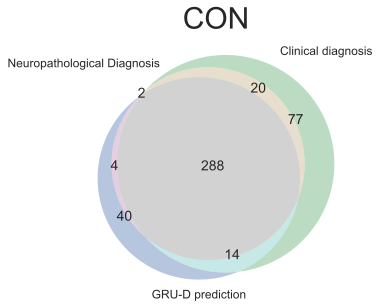

In [23]:
venndiagnoses = ['CON'] ##'CON',
# venndiagnoses = ['MND'] ##'CON',
for i in venndiagnoses:
    ## first we have to select all donors that have AD or dementia in one of the three columns
    venndf = both[(both['neuropathological_diagnosis'] ==i) | (both['parsed_clinical_diagnosis']=='other') | \
                  (both['pred'].str.contains(i)) ]
    # venndf = venndf[['DonorID','neuropathological_diagnosis','parsed_clinical_diagnosis','pred']].copy()
    display(len(venndf))
    display(venndf)
    nponly = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((venndf['parsed_clinical_diagnosis'] != 'other')) & \
                        (venndf['pred'] != i)]
    predonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] != 'other')) & \
                          (venndf['pred'] == i)]
    clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'] == 'other')) & \
                          (venndf['pred'] != i)]
    notnp = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                       ((venndf['parsed_clinical_diagnosis'] == 'other')) & \
                       (venndf['pred'] == i)]
    notpred = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'] == 'other')) &\
                         (~venndf['pred'].str.contains(i))]
    notclin = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                         ((venndf['parsed_clinical_diagnosis'] != 'other')) & \
                         (venndf['pred'] == i)]
    allthree = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                          ((venndf['parsed_clinical_diagnosis'] == 'other')) &\
                           (venndf['pred'].str.contains(i) )]
    display(predonly)
    # common_elements = list(set(list(allthree['DonorID'])).intersection(list(notpred['DonorID'])))
    # print(common_elements)
    print(f"ND only {len(nponly)}")
    print(f"pred only {len(predonly)}")
    print(f"clin only {len(clinonly)}")
    print(f"clin+pred {len(notnp)}")
    print(f"clin + ND {len(notpred)}")
    print(f"pred+ND {len(notclin)}")
    print(f"all three {len(allthree)}")
    print(len(nponly)+len(predonly)+len(clinonly)+len(notnp)+len(notpred)+len(notclin)+len(allthree))
    venn = venn3(
        subsets=(len(nponly), len(clinonly),len(notpred), len(predonly),len(notclin), len(notnp) , len(allthree)),
        set_labels=('Neuropathological Diagnosis', 'Clinical diagnosis', 'GRU-D prediction'),
        normalize_to=1
    )
    for text in venn.set_labels:
        text.set_fontsize(12)
    for text in venn.subset_labels:
        if text is not None:
            text.set_fontsize(14)
    plt.title(i)
    plt.show()


357

,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
17,NBB 1997-031,PD,1997,PD,coherent,PD,coherent
32,NBB 1997-052,PD,1997,PD,coherent,PD,coherent
37,NBB 1997-064,PD,1997,PD,coherent,PD,coherent
41,NBB 1997-072,PSP,1997,"PD,PSP",ambiguous,PD,non-coherent
66,NBB 1997-122,PD,1997,PD,coherent,PD,coherent
...,...,...,...,...,...,...,...
1791,NBB 2019-131,MSA,2019,PD,non-coherent,PD,non-coherent
1797,NBB 2020-014,PD,2020,PD,coherent,PD,coherent
1798,NBB 2020-017,PD,2020,PD,coherent,PD,coherent
1799,NBB 2020-018,PD,2020,PD,coherent,PD,coherent


,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
69,NBB 1997-125,AD,1997,dementia,ambiguous,PD,non-coherent
100,NBB 1998-008,MSA,1998,MSA,coherent,PD,non-coherent
255,NBB 1999-105,AD,1999,dementia,ambiguous,PD,non-coherent
412,NBB 2001-095,AD,2001,AD,coherent,PD,non-coherent
413,NBB 2001-096,CON,2001,other,coherent,PD,non-coherent
461,NBB 2002-029,PSP,2002,PSP,coherent,PD,non-coherent
474,NBB 2002-054,MSA,2002,MSA,coherent,PD,non-coherent
519,NBB 2003-019,MSA,2003,MSA,coherent,PD,non-coherent
539,NBB 2003-050,AD-DLB,2003,DLB,ambiguous,PD,non-coherent
609,NBB 2004-036,MSA,2004,MSA,coherent,PD,non-coherent


ND only 11
pred only 55
clin only 31
clin+pred 35
clin + ND 9
pred+ND 10
all three 206
357


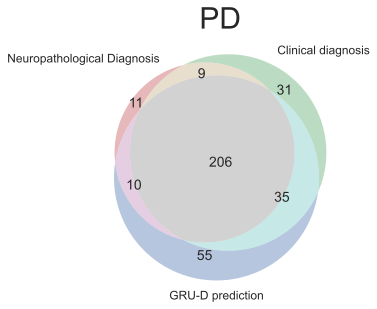

23

,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
432,NBB 2001-134,MSA,2001,ATAXIA,non-coherent,MSA,coherent
447,NBB 2002-009,MSA,2002,ATAXIA,non-coherent,MSA,coherent
467,NBB 2002-044,ATAXIA,2002,MSA,non-coherent,MSA,non-coherent
676,NBB 2005-042,ATAXIA,2005,"AD,MS",non-coherent,AD,non-coherent
727,NBB 2006-024,ATAXIA,2006,ATAXIA,coherent,AD,non-coherent
759,NBB 2006-067,ATAXIA,2006,ATAXIA,coherent,PSP,non-coherent
799,NBB 2007-040,ATAXIA,2007,ATAXIA,coherent,FTD,non-coherent
801,NBB 2007-045,ATAXIA,2007,other,non-coherent,MSA,non-coherent
807,NBB 2007-051,ATAXIA,2007,MSA,non-coherent,PSP,non-coherent
818,NBB 2007-065,ATAXIA,2007,PSP,non-coherent,MSA,non-coherent


,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info


ND only 12
pred only 0
clin only 4
clin+pred 0
clin + ND 7
pred+ND 0
all three 0
23


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


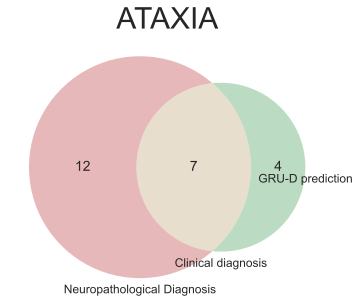

31

,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
50,NBB 1997-089,FTD,1997,"MND,FTD",ambiguous,FTD,coherent
153,NBB 1998-098,MND,1998,MND,coherent,CON,non-coherent
272,NBB 1999-134,MND,1999,MND,coherent,MSA,non-coherent
386,NBB 2001-060,AD,2001,"AD,MND",ambiguous,AD,coherent
420,NBB 2001-115,FTD,2001,"MND,FTD",ambiguous,FTD,coherent
466,NBB 2002-043,MND,2002,MND,coherent,MND,coherent
489,NBB 2002-075,FTD,2002,MND,non-coherent,FTD,coherent
521,NBB 2003-022,MND,2002,MND,coherent,MND,coherent
549,NBB 2003-063,MND,2003,MND,coherent,MSA,non-coherent
590,NBB 2004-013,FTD,2004,MND,non-coherent,FTD,coherent


,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
1052,NBB 2010-094,MSA,2010,MSA,coherent,MND,non-coherent


ND only 0
pred only 1
clin only 14
clin+pred 0
clin + ND 11
pred+ND 0
all three 5
31


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


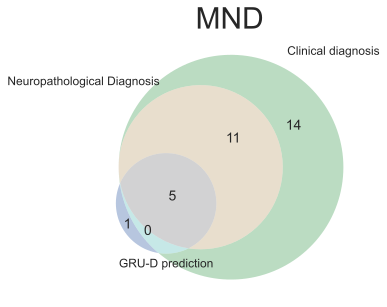

110

,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
41,NBB 1997-072,PSP,1997,"PD,PSP",ambiguous,PD,non-coherent
83,NBB 1997-148,AD,1997,"PSP,FTD",non-coherent,AD,coherent
137,NBB 1998-068,PSP,1998,other,non-coherent,MSA,non-coherent
208,NBB 1999-018,PSP,1999,PD,non-coherent,PD,non-coherent
211,NBB 1999-024,PSP,1999,FTD,non-coherent,PSP,coherent
...,...,...,...,...,...,...,...
1718,NBB 2018-124,MSA,2018,"PD,MSA",ambiguous,PSP,non-coherent
1728,NBB 2019-002,FTD,2019,"FTD,PSP",ambiguous,PSP,non-coherent
1732,NBB 2019-009,PSP,2019,PSP,coherent,PSP,coherent
1782,NBB 2019-106,PSP,2019,other,non-coherent,AD,non-coherent


,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
682,NBB 2005-050,PD,2005,MSA,non-coherent,PSP,non-coherent
759,NBB 2006-067,ATAXIA,2006,ATAXIA,coherent,PSP,non-coherent
807,NBB 2007-051,ATAXIA,2007,MSA,non-coherent,PSP,non-coherent
826,NBB 2007-077,FTD,2007,other,non-coherent,PSP,non-coherent
847,NBB 2008-013,AD,2008,dementia,ambiguous,PSP,non-coherent
887,NBB 2008-078,FTD,2008,other,non-coherent,PSP,non-coherent
1175,NBB 2012-011,PD,2012,PD,coherent,PSP,non-coherent
1306,NBB 2013-067,MSA,2013,MSA,coherent,PSP,non-coherent
1312,NBB 2013-078,PD,2013,PD,coherent,PSP,non-coherent
1527,NBB 2016-096,MSA,2016,MSA,coherent,PSP,non-coherent


ND only 31
pred only 14
clin only 7
clin+pred 3
clin + ND 21
pred+ND 6
all three 28
110


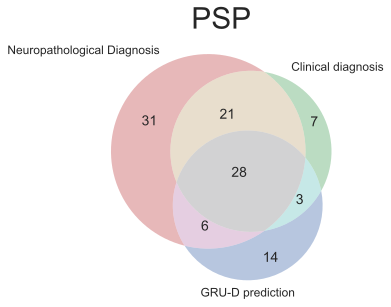

351

,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
4,NBB 1997-006,MS,1997,MS,coherent,MS,coherent
21,NBB 1997-035,MSA,1997,MSA,coherent,FTD,non-coherent
30,NBB 1997-050,MS,1997,MS,coherent,MS,coherent
33,NBB 1997-053,VD,1997,FTD,non-coherent,MS,non-coherent
39,NBB 1997-070,MS,1997,MS,coherent,MS,coherent
...,...,...,...,...,...,...,...
1755,NBB 2019-047,MS,2019,MS,coherent,MS,coherent
1778,NBB 2019-100,PD,2019,"PD,MSA",ambiguous,PD,coherent
1784,NBB 2019-120,MSA,2019,"PD,MSA",ambiguous,PD,non-coherent
1804,NBB 2020-052,CON,2020,other,coherent,MS,non-coherent


,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
33,NBB 1997-053,VD,1997,FTD,non-coherent,MS,non-coherent
88,NBB 1997-159,CON,1997,other,coherent,MS,non-coherent
96,NBB 1998-003,CON,1998,other,coherent,MS,non-coherent
227,NBB 1999-052,CON,1999,other,coherent,MS,non-coherent
268,NBB 1999-125,CON,1999,other,coherent,MS,non-coherent
277,NBB 1999-142,VD,1999,other,non-coherent,MS,non-coherent
343,NBB 2000-127,CON,2000,other,coherent,MS,non-coherent
351,NBB 2001-004,CON,2001,other,coherent,MS,non-coherent
369,NBB 2001-028,CON,2001,other,coherent,MS,non-coherent
402,NBB 2001-083,CON,2001,other,coherent,MS,non-coherent


ND only 3
pred only 41
clin only 70
clin+pred 1
clin + ND 17
pred+ND 3
all three 198
333


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


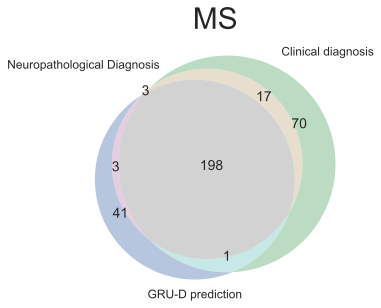

99

,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
21,NBB 1997-035,MSA,1997,MSA,coherent,FTD,non-coherent
100,NBB 1998-008,MSA,1998,MSA,coherent,PD,non-coherent
129,NBB 1998-057,MSA,1998,"MSA,PD",ambiguous,MSA,coherent
137,NBB 1998-068,PSP,1998,other,non-coherent,MSA,non-coherent
272,NBB 1999-134,MND,1999,MND,coherent,MSA,non-coherent
...,...,...,...,...,...,...,...
1763,NBB 2019-064,MSA,2019,other,non-coherent,PD,non-coherent
1778,NBB 2019-100,PD,2019,"PD,MSA",ambiguous,PD,coherent
1784,NBB 2019-120,MSA,2019,"PD,MSA",ambiguous,PD,non-coherent
1791,NBB 2019-131,MSA,2019,PD,non-coherent,PD,non-coherent


,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info
137,NBB 1998-068,PSP,1998,other,non-coherent,MSA,non-coherent
272,NBB 1999-134,MND,1999,MND,coherent,MSA,non-coherent
549,NBB 2003-063,MND,2003,MND,coherent,MSA,non-coherent
801,NBB 2007-045,ATAXIA,2007,other,non-coherent,MSA,non-coherent
818,NBB 2007-065,ATAXIA,2007,PSP,non-coherent,MSA,non-coherent
858,NBB 2008-030,ATAXIA,2008,ATAXIA,coherent,MSA,non-coherent
860,NBB 2008-034,PSP,2008,PSP,coherent,MSA,non-coherent
933,NBB 2009-037,PSP,2009,PSP,coherent,MSA,non-coherent
1447,NBB 2015-086,MND,2015,MND,coherent,MSA,non-coherent
1529,NBB 2016-098,PD,2016,PD,coherent,MSA,non-coherent


ND only 12
pred only 13
clin only 23
clin+pred 6
clin + ND 21
pred+ND 5
all three 19
99


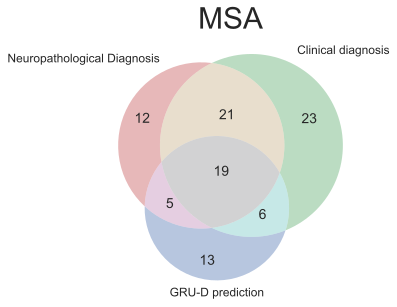

In [24]:
venndiagnoses = ['PD','ATAXIA', 'MND', 'PSP', 'MS', 'MSA'] ##'CON',
# venndiagnoses = ['MND'] ##'CON',
for i in venndiagnoses:
    ## first we have to select all donors that have AD or dementia in one of the three columns
    venndf = both[(both['neuropathological_diagnosis'] ==i) | (both['parsed_clinical_diagnosis'].str.contains(i)) | \
                  (both['pred'].str.contains(i)) ]
    # venndf = venndf[['DonorID','neuropathological_diagnosis','parsed_clinical_diagnosis','pred']].copy()
    display(len(venndf))
    display(venndf)
    nponly = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((~venndf['parsed_clinical_diagnosis'].str.contains(i))) & \
                        (venndf['pred'] != i)]
    predonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((~venndf['parsed_clinical_diagnosis'].str.contains(i))) & \
                          (venndf['pred'] == i)]
    display(predonly)
    clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'].str.contains(i))) & \
                          (venndf['pred'] != i)]
    notnp = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                       ((venndf['parsed_clinical_diagnosis'].str.contains(i))) & \
                       (venndf['pred'] == i)]
    notpred = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'].str.contains(i))) &\
                         (~venndf['pred'].str.contains(i))]
    notclin =venndf[(venndf['neuropathological_diagnosis'] == i) & \
                         ((~venndf['parsed_clinical_diagnosis'].str.contains(i))) & \
                         (venndf['pred'] == i)]
    allthree = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                          ((venndf['parsed_clinical_diagnosis'].str.contains(i))) &\
                           (venndf['pred'].str.contains(i) )]
    # common_elements = list(set(list(allthree['DonorID'])).intersection(list(notpred['DonorID'])))
    # print(common_elements)
    print(f"ND only {len(nponly)}")
    print(f"pred only {len(predonly)}")
    print(f"clin only {len(clinonly)}")
    print(f"clin+pred {len(notnp)}")
    print(f"clin + ND {len(notpred)}")
    print(f"pred+ND {len(notclin)}")
    print(f"all three {len(allthree)}")
    print(len(nponly)+len(predonly)+len(clinonly)+len(notnp)+len(notpred)+len(notclin)+len(allthree))
    venn = venn3(
        subsets=(len(nponly), len(clinonly),len(notpred), len(predonly),len(notclin), len(notnp) , len(allthree)),
        set_labels=('Neuropathological Diagnosis', 'Clinical diagnosis', 'GRU-D prediction'),
        normalize_to=1
    )
    for text in venn.set_labels:
        text.set_fontsize(12)
    for text in venn.subset_labels:
        if text is not None:
            text.set_fontsize(14)
    plt.title(i)
    plt.show()


### jaccard

In [25]:
jacdf = both[['neuropathological_diagnosis','DonorID','parsed_clinical_diagnosis','pred']]
jacdf

venndiagnoses = ['PD','ATAXIA', 'MND', 'PSP', 'MS', 'MSA'] ##'CON',
# venndiagnoses = ['MSA'] ##'CON',
for i in venndiagnoses:
    print(i)
    ## first we have to select all donors that have AD or dementia in one of the three columns
    venndf = jacdf[(jacdf['neuropathological_diagnosis'] ==i) | (jacdf['parsed_clinical_diagnosis'].str.contains(i)) | \
                  (jacdf['pred'].str.contains(i)) ]
    # venndf = venndf[['DonorID','neuropathological_diagnosis','parsed_clinical_diagnosis','pred']].copy()
    # display(len(venndf))
    # display(venndf)

    clin_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'].str.contains(i)))]
    clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'].str.contains(i)))]
    nponly_clin = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((~venndf['parsed_clinical_diagnosis'].str.contains(i)))]
    
    grud_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['pred'] == i))]
    grudonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['pred'] == i))]
    nponly_grud = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((venndf['pred'] != i))]

    # display(clin_ND_set)
#     display(clinonly)
#     display(nponly)
    
#     display(len(grud_ND_set))
#     display(len(grudonly))
#     display(len(nponly_grud))
    
    clin_jaccard = len(clin_ND_set)/(len(clinonly)+len(nponly_clin)+len(clin_ND_set))
    grud_jaccard = len(grud_ND_set)/(len(grudonly)+len(nponly_grud)+len(grud_ND_set))
    print(round(clin_jaccard,3))
    print(round(grud_jaccard,3))

PD
0.712
0.663
ATAXIA
0.304
0.0
MND
0.533
0.294
PSP
0.51
0.33
MS
0.736
0.764
MSA
0.465
0.316


In [26]:
jacdf = both[['neuropathological_diagnosis','DonorID','parsed_clinical_diagnosis','pred']]
jacdf

venndiagnoses = ['AD','FTD','VD','DLB']
# venndiagnoses = ['AD'] ##'CON',
for i in venndiagnoses:
    print(i)
    ## first we have to select all donors that have AD or dementia in one of the three columns
    venndf = jacdf[(jacdf['neuropathological_diagnosis'] ==i) | (jacdf['parsed_clinical_diagnosis'].str.contains(i)) | \
                  (jacdf['pred'].str.contains(i)) ]
    # venndf = venndf[['DonorID','neuropathological_diagnosis','parsed_clinical_diagnosis','pred']].copy()
    # display(len(venndf))
    # display(venndf)

    clin_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | (venndf['parsed_clinical_diagnosis']=='dementia'))]
    clinonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['parsed_clinical_diagnosis'].str.contains(i)) | (venndf['parsed_clinical_diagnosis']=='dementia'))]
    nponly_clin = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((~venndf['parsed_clinical_diagnosis'].str.contains(i)) & (venndf['parsed_clinical_diagnosis']!='dementia'))]
    
    grud_ND_set = venndf[(venndf['neuropathological_diagnosis'] == i) &\
                         ((venndf['pred'] == i))]
    grudonly = venndf[(venndf['neuropathological_diagnosis'] != i) & \
                          ((venndf['pred'] == i))]
    nponly_grud = venndf[(venndf['neuropathological_diagnosis'] == i) & \
                        ((venndf['pred'] != i))]


    # display(clin_ND_set)
    # display(clinonly)
    # display(nponly_clin)
    
    display(len(grud_ND_set))
    display(len(grudonly))
    display(len(nponly_grud))
    
    clin_jaccard = len(clin_ND_set)/(len(clinonly)+len(nponly_clin)+len(clin_ND_set))
    grud_jaccard = len(grud_ND_set)/(len(grudonly)+len(nponly_grud)+len(grud_ND_set))
    print(round(clin_jaccard,3))
    print(round(grud_jaccard,3))

AD


423

200

54

0.654
0.625
FTD


128

54

68

0.643
0.512
VD


2

2

51

0.208
0.036
DLB


0

0

29

0.247
0.0


### scatterplot

1000


,diagnosis_info,pred_info,diagnosis_info_lenient,pred_info_lenient,overlap_strict,overlap_lenient,dot_strict,dot_lenient
neuropathological_diagnosis,,,,,,,,
AD,60.587002,88.679245,84.067086,89.098532,56.603774,77.777778,609.433962,800.000000
AD-DLB,2.912621,0.970874,75.728155,81.553398,0.000000,63.106796,100.000000,667.961165
ATAXIA,36.842105,0.000000,36.842105,0.000000,0.000000,0.000000,100.000000,100.000000
CON,98.089172,92.993631,98.089172,92.993631,91.719745,91.719745,925.477707,925.477707
DLB,41.379310,0.000000,68.965517,0.000000,0.000000,0.000000,100.000000,100.000000
FTD,69.387755,65.306122,82.653061,65.306122,50.000000,59.183673,550.000000,632.653061
MND,100.000000,31.250000,100.000000,31.250000,31.250000,31.250000,381.250000,381.250000
MS,95.927602,90.950226,97.285068,90.950226,88.235294,89.592760,894.117647,906.334842
MSA,33.333333,42.105263,70.175439,42.105263,14.035088,33.333333,226.315789,400.000000


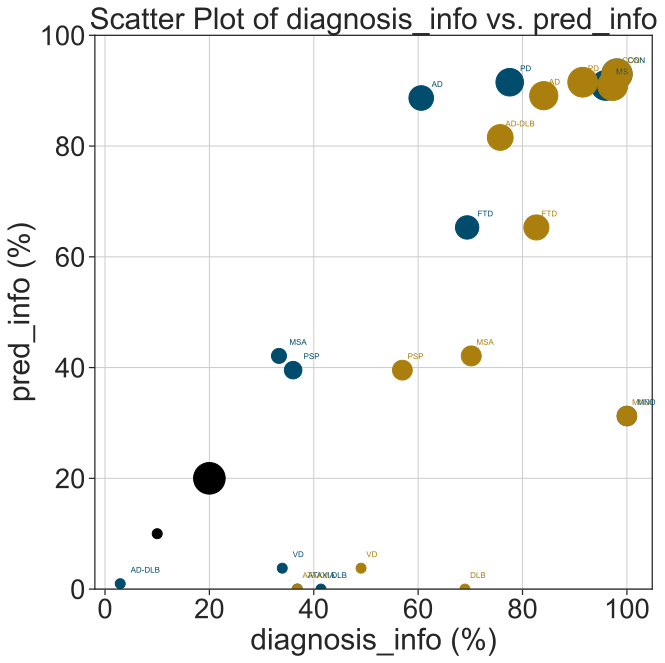

In [27]:
scatter = both[['DonorID','neuropathological_diagnosis','diagnosis_info','pred_info']].copy()
# display(scatter)

import matplotlib.lines as mlines
# wantedx
overlap_percentages = {}
overlap_percentages_lenient = {}
# Calculate overlap percentage for each diagnosis
for diagnosis in wantedx:
    diagnosis_df = scatter[scatter['neuropathological_diagnosis'] == diagnosis]
    overlap_percentage = (
        ((diagnosis_df['diagnosis_info'] == 'coherent') & (diagnosis_df['pred_info'] == 'coherent')).sum() / len(diagnosis_df) * 100
    )
    overlap_percentages[diagnosis] = overlap_percentage

    

for diagnosis in wantedx:
    diagnosis_df = scatter[scatter['neuropathological_diagnosis'] == diagnosis]
    overlap_percentage = (
        ((diagnosis_df['diagnosis_info'] != 'non-coherent') & (diagnosis_df['pred_info'] != 'non-coherent')).sum() / len(diagnosis_df) * 100
    )
    overlap_percentages_lenient[diagnosis] = overlap_percentage

## Convert the dictionary to a DataFrame
overlap_df = pd.DataFrame.from_dict(overlap_percentages, orient='index', columns=['overlap_strict'])
overlap_df_lenient = pd.DataFrame.from_dict(overlap_percentages_lenient, orient='index', columns=['overlap_lenient'])
# display(overlap_df)


# Display the updated scatterdf
# print(scatterdf)

scatterpc = scatter.pivot_table(
    values=['diagnosis_info', 'pred_info'],
    index='neuropathological_diagnosis',
    aggfunc=lambda x: (x == 'coherent').mean() * 100
)

scatterpc['diagnosis_info_lenient'] = scatter.pivot_table(
    values='diagnosis_info',
    index='neuropathological_diagnosis',
    aggfunc=lambda x: ((x == 'coherent') | (x == 'ambiguous')).mean() * 100
)

scatterpc['pred_info_lenient'] = scatter.pivot_table(
    values='pred_info',
    index='neuropathological_diagnosis',
    aggfunc=lambda x: ((x == 'coherent') | (x == 'ambiguous')).mean() * 100
)
scatterpc = scatterpc.merge(overlap_df, left_on='neuropathological_diagnosis', right_index=True)
scatterpc = scatterpc.merge(overlap_df_lenient, left_on='neuropathological_diagnosis', right_index=True)

min_dot_size = 100
max_dot_size = 1000
scatterpc['dot_strict'] = min_dot_size + (max_dot_size - min_dot_size) * (scatterpc['overlap_strict'] / 100)
scatterpc['dot_lenient'] = min_dot_size + (max_dot_size - min_dot_size) * (scatterpc['overlap_lenient'] / 100)

print( min_dot_size + (max_dot_size - min_dot_size))
display(scatterpc)
# Create a scatter plot
plt.figure(figsize=(10,10))

plt.scatter(
    scatterpc['diagnosis_info'],
    scatterpc['pred_info'],
    c='#004c6d',  # Use the desired color
    label='strict',
    marker='o',
    s=scatterpc['dot_strict'] 
)

plt.scatter(
    scatterpc['diagnosis_info_lenient'],
    scatterpc['pred_info_lenient'],
    c='#aa7f0e',  # Use the desired color
    label='lenient',
    marker='o',
    s=scatterpc['dot_lenient'] 
)

plt.scatter(
    10,
    10,
    c='black',
    s = min_dot_size
    
)
plt.scatter(
    20,
    20,
    c='black',
    s = min_dot_size + (max_dot_size - min_dot_size)
    
)

# Label the scatter points with neuropathological_diagnosis
for i, diagnosis in enumerate(scatterpc.index):
    plt.text(scatterpc['diagnosis_info'][i]+2, scatterpc['pred_info'][i] + 2, diagnosis, fontsize=8, color='#004c6d')
    plt.text(scatterpc['diagnosis_info_lenient'][i]+1, scatterpc['pred_info_lenient'][i] + 2, diagnosis, fontsize=8,color='#aa7f0e')
plt.ylim(0,100)
# Add labels and title
plt.xlabel('diagnosis_info (%)')
plt.ylabel('pred_info (%)')
plt.title('Scatter Plot of diagnosis_info vs. pred_info')

# Add legend
# plt.legend(loc='best')

# Show the plot
plt.grid()
plt.savefig('/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/figures/scatter.pdf', format='pdf', dpi=600)     
plt.show()

# '#004c6d', '#aa7f0e',

In [12]:
def add_model_vs_clinic_column(df):
    # Define the conditions and the corresponding values for the new column
    conditions = [
        (df['pred_info'] == 'coherent') & (df['diagnosis_info'] == 'coherent'), ##'both_coherent'
        (df['pred_info'] == 'non-coherent') & (df['diagnosis_info'] == 'coherent'), ##clin_coh_model_non_coh
        (df['pred_info'] == 'ambiguous') & (df['diagnosis_info'] == 'coherent'), ##'clin_coh_model_ambiguous'
        (df['pred_info'] == 'non-coherent') & (df['diagnosis_info'] == 'ambiguous'), ##clin_amb_model_non_coh
        (df['pred_info'] == 'coherent') & (df['diagnosis_info'] == 'non-coherent'), ##model_coh_clin_non_coh
        (df['pred_info'] == 'coherent') & (df['diagnosis_info'] == 'ambiguous'), ##model_coh_clin_ambiguous
        (df['pred_info'] == 'ambiguous') & (df['diagnosis_info'] == 'non-coherent'), ## model_amb_clin_non_coh
        (df['pred_info'] == 'non-coherent') & (df['diagnosis_info'] == 'non-coherent'),  ##both_non_coh
        (df['pred_info'] == 'ambiguous') & (df['diagnosis_info'] == 'ambiguous'), ## both ambh
    ]

    values = ['both_coherent',\
               'clin_coh_model_non_coh', 'clin_coh_model_ambiguous','clin_amb_model_non_coh',\
               'model_coh_clin_non_coh','model_coh_clin_ambiguous','model_amb_clin_non_coh',\
               'both_non_coh','both_amb']

    # Use np.select to assign values based on the conditions
    df['model_vs_clinic'] = np.select(conditions, values, default=None)

# Example usage:
# Apply the function to the DataFrame "ms_diagnosed_donors"
add_model_vs_clinic_column(both)
add_model_vs_clinic_column(both_full)
display(both.tail(5))
display(both_full.tail(5))
both.to_excel('/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/data/grud_clin_subset_overview_both.xlsx', index=False)
both_full.to_excel('/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_analysis/data/grud_clin_subset_full_overview_both.xlsx', index=False)

,DonorID,neuropathological_diagnosis,death_year,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info,model_vs_clinic
1802,NBB 2020-029,PSP,2020,FTD,non-coherent,FTD,non-coherent,both_non_coh
1803,NBB 2020-030,MSA,2020,PD,non-coherent,PD,non-coherent,both_non_coh
1804,NBB 2020-052,CON,2020,other,coherent,MS,non-coherent,clin_coh_model_non_coh
1805,NBB 2020-054,CON,2020,other,coherent,MS,non-coherent,clin_coh_model_non_coh
1806,NBB 2020-078,FTD,2020,FTD,coherent,FTD,coherent,both_coherent


,Origin,DonorID,Year,clinical_diagnosis,neuropathological_diagnosis,simplified_diagnosis,death_year,clinical_diagnosis_raw,table1diag,parsed_clinical_diagnosis,diagnosis_info,pred,pred_info,model_vs_clinic
15580,part3,NBB 2020-078,2016,not_relevant,FTD,FTD,2020,coronary artery disease,not_relevant,FTD,coherent,FTD,coherent,both_coherent
15581,part2,NBB 2020-078,2020,not_relevant,FTD,FTD,2020,NaN,not_relevant,FTD,coherent,FTD,coherent,both_coherent
15582,part2,NBB 2020-078,year unknown,not_relevant,FTD,FTD,2020,NaN,not_relevant,FTD,coherent,FTD,coherent,both_coherent
15583,part2,NBB 2020-078,year unknown,not_relevant,FTD,FTD,2020,NaN,not_relevant,FTD,coherent,FTD,coherent,both_coherent
15584,part2,NBB 2020-078,year unknown,not_relevant,FTD,FTD,2020,not_relevant,not_relevant,FTD,coherent,FTD,coherent,both_coherent


In [13]:
# both[both['neuropathological_diagnosis'] == 'FTD']['diagnosis_info'].value_counts()
# display(both[both['model_vs_clinic'] == 'both_non_coh']['neuropathological_diagnosis'].value_counts())
display(both[both['diagnosis_info'] == 'non-coherent']['neuropathological_diagnosis'].value_counts())
display(both[both['neuropathological_diagnosis'] == 'AD-DLB']['model_vs_clinic'].value_counts())
display(both['model_vs_clinic'].value_counts())
# both['model_vs_clinic'].value_counts()

AD        80
FTD       40
PSP       37
PD        37
VD        28
AD-DLB    20
MSA       18
ATAXIA    12
DLB        9
CON        6
MS         6
Name: neuropathological_diagnosis, dtype: int64

both_amb                    66
model_amb_clin_non_coh      15
clin_amb_model_non_coh      14
both_non_coh                 5
clin_coh_model_ambiguous     2
model_coh_clin_ambiguous     1
Name: model_vs_clinic, dtype: int64

both_coherent               1080
clin_coh_model_non_coh       189
both_non_coh                 158
model_coh_clin_ambiguous     126
model_coh_clin_non_coh       120
both_amb                      67
clin_amb_model_non_coh        49
model_amb_clin_non_coh        15
clin_coh_model_ambiguous       3
Name: model_vs_clinic, dtype: int64

In [14]:
# Select all donors with neuropathological diagnosis "MS"
overview = []
for diagnosis in both['neuropathological_diagnosis'].unique():
    # print(diagnosis)
    diagnosed_donors = both[both['neuropathological_diagnosis'] == diagnosis]
    # display(diagnosed_donors)
    # Calculate the counts for each category
    both_coherent = diagnosed_donors[diagnosed_donors['model_vs_clinic'] == 'both_coherent']
    doctor_coherent_model_non_coherent = diagnosed_donors[(diagnosed_donors['model_vs_clinic'] == 'clin_coh_model_non_coh') |\
                                                          (diagnosed_donors['model_vs_clinic'] == 'clin_coh_model_ambiguous')]
    # doctor_coherent_model_ambiguous = diagnosed_donors[diagnosed_donors['model_vs_clinic'] == 'clin_coh_model_ambiguous']
    doctor_ambiguous_model_non_coherent = diagnosed_donors[(diagnosed_donors['model_vs_clinic'] == 'clin_amb_model_non_coh')|\
                                                           (diagnosed_donors['model_vs_clinic'] == 'model_amb_clin_non_coh') |\
                                                           (diagnosed_donors['model_vs_clinic'] == 'both_non_coh')|\
                                                           (diagnosed_donors['model_vs_clinic'] == 'both_amb')
                                                          ]
    model_coherent_doctor_non_coherent =diagnosed_donors[(diagnosed_donors['model_vs_clinic'] == 'model_coh_clin_non_coh')|\
                                                         (diagnosed_donors['model_vs_clinic'] == 'model_coh_clin_ambiguous')]
    # model_coherent_doctor_ambiguous =diagnosed_donors[diagnosed_donors['model_vs_clinic'] == 'model_coh_clin_ambiguous']
    # model_amb_clin_non_coh = diagnosed_donors[diagnosed_donors['model_vs_clinic'] == 'model_amb_clin_non_coh']
    # both_non_coherent = diagnosed_donors[diagnosed_donors['model_vs_clinic'] == 'both_non_coh']
    # ambiguous_by_both = diagnosed_donors[diagnosed_donors['model_vs_clinic'] == 'both_amb']
    

    overview.append([diagnosis, len(both_coherent), \
                     len(doctor_coherent_model_non_coherent),#len(doctor_coherent_model_ambiguous),
                     len(doctor_ambiguous_model_non_coherent), \
                     len(model_coherent_doctor_non_coherent),#len(model_coherent_doctor_ambiguous),
                     # len(model_amb_clin_non_coh), \
                     # len(both_non_coherent),len(ambiguous_by_both)
                    ])
# display(overview)
# print(len(overview))    
columns = ['diagnosis', 'both_coherent',\
           'clin_coh', #'clin_coh_model_ambiguous',
           'ambiguous_or_non_coherent',\
           'model_coh',#'model_coh_clin_ambiguous',
           # 'model_amb_clin_non_coh',\
           # 'both_non_coh','both_ambiguous'
          ]
diagnosis_df = pd.DataFrame(overview, columns=columns)

# Set the 'diagnosis' column as the index for easier plotting
diagnosis_df.set_index('diagnosis', inplace=True)
# wantedx = ['CON','AD', 'PD', 'VD', 'FTD', 'DLB', 'AD-DLB', 'ATAXIA', 'MND', 'PSP', 'MS', 'MSA']
# diagnosis_df.index = pd.Categorical(diagnosis_df.index, categories=wantedx)
# diagnosis_df = diagnosis_df.sort_index(axis=0).sort_index(axis=1)
diagnosis_df = diagnosis_df.reindex(wantedx)
diagnosis_df = diagnosis_df.iloc[::-1]
display(diagnosis_df)


,both_coherent,clin_coh,ambiguous_or_non_coherent,model_coh
diagnosis,,,,
MSA,15,19,14,9
MS,196,17,3,5
PSP,24,17,35,10
MND,5,11,0,0
ATAXIA,0,7,12,0
AD-DLB,0,2,100,1
DLB,0,14,15,0
FTD,101,39,29,27
VD,0,18,33,2


/tmp/ipykernel_3373/2844055959.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


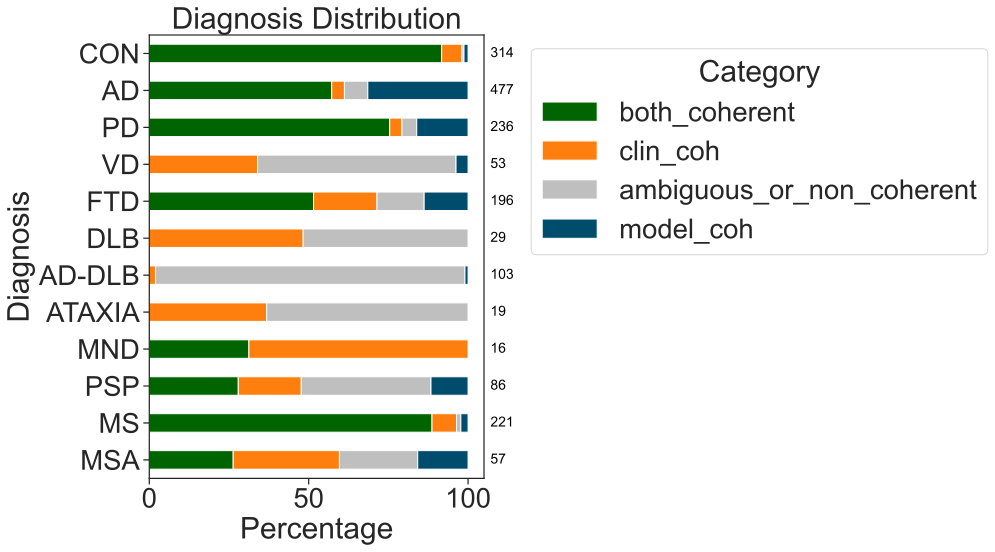

In [15]:

total_counts = diagnosis_df.sum(axis=1)
# display(diagnosis_df)
diagnosis_df_percentage = diagnosis_df.divide(total_counts, axis=0) * 100
# display(diagnosis_df_percentage)
# Plot the horizontal stacked bar chart with percentages
# colors = ['#004c6d', '#aa7f0e', '#ff7f0e']
colors = ['darkgreen','#aa7f0e', '#004c6d', 'grey']
colors = {
    'both_coherent': 'darkgreen',
    'clin_coh': '#ff7f0e',
    'clin_coh_model_non_coh': '#ff7f0e',
    'clin_coh_model_ambiguous': '#f2cc8f',
    'model_coh': '#004c6d',
    'model_coh_clin_non_coh': '#004c6d',
    'model_coh_clin_ambiguous': '#6699cc',
    'both_non_coh': '#404040',
    'both_ambiguous': 'pink',
    'clin_amb_model_non_coh':'#7f7f7f',
    'model_amb_clin_non_coh':'#bfbfbf',
    'ambiguous_or_non_coherent':'#bfbfbf'
}
ax = diagnosis_df_percentage.plot(kind='barh', stacked=True, figsize=(6, 8), color=colors)


# Set the title and labels
plt.title('Diagnosis Distribution')
plt.xlabel('Percentage')
plt.ylabel('Diagnosis')

# Show the legend
plt.legend(title='Category', bbox_to_anchor=(1.1, 1))
for i, count in enumerate(total_counts):
    plt.text(107, i, f"{count}", ha='left', va='center', color='black', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

## old

In [32]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   None, List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
#         group_counts = ["{0:.2f}  \n".format(value) for value in cf.flatten()]
        group_counts = []
        for value in cf.flatten():
            if value == 0:
                group_counts.append('0')
            else:
                group_counts.append(value)
#         group_counts = ["{} \n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,
                xticklabels=categories,
                yticklabels=categories,
                annot_kws={"size": 16})
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    if xyplotlabels:
        plt.ylabel('True label',labelpad=0)#,fontsize=16)
        plt.xlabel('Predicted label' + stats_text,labelpad=10)#,fontsize=16)
    else:
        plt.xlabel(stats_text)#,fontsize=16)
    if title:
        plt.title(title)#,fontsize=16)

In [33]:
pd.set_option('display.max_rows', 500)

fold:  0
f1score
0.7651933701657458
fold:  1
f1score
0.7265193370165745
fold:  2
f1score
0.7645429362880887
fold:  3
f1score
0.7257617728531855
fold:  4
f1score
0.7146814404432134


,precision,recall,f1-score,support,Jaccard
CON,0.8396,0.9424,0.8876,62.8,0.798624
AD,0.6802,0.8972,0.7732,95.4,0.630783
PD,0.7026,0.8984,0.7884,47.2,0.651104
VD,0.8000,0.0000,0.0000,10.6,0.000000
FTD,0.7442,0.6682,0.7014,39.2,0.541639
DLB,1.0000,0.0000,0.0000,5.8,0.000000
"AD,DLB",0.6000,0.0000,0.0000,20.6,0.000000
ATAXIA,1.0000,0.1166,0.1800,3.8,0.116667
MND,0.8834,0.4834,0.4834,3.2,0.420000
PSP,0.6382,0.4072,0.4886,17.2,0.332352


array([[0.94, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04,
        0.  ],
       [0.03, 0.9 , 0.02, 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.01, 0.06, 0.9 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
        0.02],
       [0.28, 0.32, 0.06, 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.3 ,
        0.  ],
       [0.01, 0.27, 0.03, 0.  , 0.67, 0.  , 0.  , 0.  , 0.01, 0.02, 0.  ,
        0.01],
       [0.03, 0.48, 0.45, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.03, 0.83, 0.09, 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
        0.  ],
       [0.05, 0.21, 0.05, 0.  , 0.05, 0.  , 0.  , 0.11, 0.  , 0.21, 0.05,
        0.26],
       [0.06, 0.  , 0.  , 0.  , 0.19, 0.  , 0.  , 0.  , 0.5 , 0.06, 0.12,
        0.06],
       [0.  , 0.12, 0.28, 0.  , 0.15, 0.  , 0.  , 0.  , 0.  , 0.41, 0.  ,
        0.05],
       [0.09, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.9 ,
        0.  ],
       [0.  , 0.02, 0

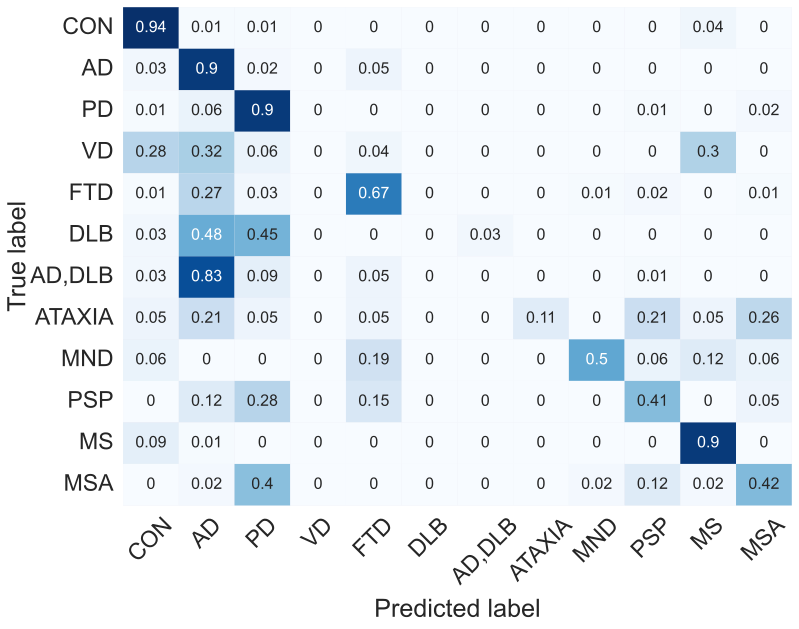

In [34]:
sns.set(font_scale=2.1)
list_of_dfs = []
full_preds = []
averages_f1 = []
confusions = []
jaccards = []

# alphabetic = ['AD', 'AD_CA','AD_VE','ATAXIA','BP','CON','DEM_SICC','DLB',  'FTD',
#               'MD','MND','MS', 'MSA','PD',  'PDD', 'PSP', 'SCHIZ', 'VD']
wanted = ['CON', 'AD', 'AD_CA', 'AD_VE', 'DEM_SICC', 'PD', 'PDD','DLB', 'VD',
          'FTD', 'MND', 'PSP','ATAXIA', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'DEM_SICC', 'PD', 'PDD','DLB', 'VD',
          'FTD', 'MND', 'PSP','ATAXIA', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'PD', 'PDD','DLB', 'VD',
          'FTD', 'MND', 'PSP','ATAXIA', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'PD', 'PDD', 'VD',
          'FTD', 'MND', 'PSP', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'PD', 'VD',
          'FTD', 'MND', 'PSP', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'PD', 'VD', 'FTD','AD,DLB','DLB','ATAXIA', 'MND', 'PSP', 'MS','MSA']
wanted = ['CON', 'AD', 'PD', 'VD', 'FTD','DLB','AD,DLB','DLB,SICC','ATAXIA', 'MND', 'PSP', 'MS','MSA'] #'AD,DLB'
wanted = ['CON', 'AD', 'PD', 'VD', 'FTD','DLB','AD,DLB','ATAXIA', 'MND', 'PSP', 'MS','MSA'] #'AD,DLB'
# wanted = ['CON', 'AD', 'PD', 'VD', 'FTD','DLB','ATAXIA', 'MND', 'PSP', 'MS','MSA'] #'AD,DLB'
for i in range(preds['pred_y_list_all'].shape[0]):
    print('fold: ',i)
    #print the prediction for the test for the nth fold
    firstfold_preds = preds['pred_y_list_all'][i][2]
    pred_df = pd.DataFrame(firstfold_preds, columns = wanted)
    b = np.zeros_like(pred_df.values)
    b[np.arange(len(pred_df)), pred_df.values.argmax(1)] = 1
    df1 = pd.DataFrame(b, columns = pred_df.columns).astype(int)
    compare = pd.DataFrame(df1.idxmax(1),columns=['predictions'])

    ## TRUTHS
    truths = np.load(path_truths, allow_pickle=True)#load(path_predictions)
    firstfold_truths = truths['true_y_list_all'][i][2]
    truth_df = pd.DataFrame(firstfold_truths, columns = wanted)
    compare['truths'] = truth_df.idxmax(1)
    full_preds.append(compare)
    
    ## F1-SCORE
    print('f1score')
    print(f1_score(compare['truths'], compare['predictions'], average='micro'))
    averages_f1.append(f1_score(compare['truths'], compare['predictions'], average='micro'))
    
    # print('nienke this is the format!')
    # display(compare)
    ## CONFUSION MATRIX
    cf_matrix= metrics.confusion_matrix(compare['truths'], compare['predictions'],
                                        labels = wanted)
    confusions.append(cf_matrix)

    ## JACCARD
    j_index = jaccard_score(y_true=compare['truths'],y_pred=compare['predictions'],labels=wanted,average=None)
    j_index_df = pd.DataFrame(j_index, columns= ['Jaccard'], index = wanted)
#     display(j_index_df)
    jaccards.append(j_index)
    
    ## CLASSIFICATION REPORT
    report = metrics.classification_report(compare['truths'], compare['predictions'], digits=3,output_dict=True, zero_division=1)
    report_df = pd.DataFrame(report).transpose()
    report_df = round(report_df,3)
    report_df['fold'] = i
    report_df = pd.concat([report_df,j_index_df],axis=1)
    wanted_plus = wanted.copy()
    new_items = ['accuracy', 'macro avg', 'weighted avg']
    wanted_plus.extend(new_items)
    report_df= report_df.reindex(wanted_plus)
    # display(report_df)
    list_of_dfs.append(report_df)

## F1-SCORE
average_f1 = np.average(averages_f1)

## JACCARD
# average_jaccard = np.array(jaccards).mean(axis=0)
# jaccard_df = pd.DataFrame(average_jaccard,columns=['Jaccard Index'],index=cols)
# jaccard_df = jaccard_df.round(decimals = 2)
# jaccard_df = jaccard_df.reindex(wanted)
# display(jaccard_df)

## CLASSIFICATION REPORT
full_report = pd.concat([list_of_dfs[0], list_of_dfs[1], list_of_dfs[2],list_of_dfs[3],list_of_dfs[4]])

full_report2 = full_report.groupby(level=0).mean()
full_report2 = full_report2.drop('fold',axis=1)
full_report2 = full_report2.reindex(wanted)
display(full_report2)
output_path = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/classification_report_{identifier}.xlsx'
full_report2.to_excel(output_path)  
# display(confusions)

## CONFUSION MATRIX
average_confusion = np.array(confusions).mean(axis=0)
vector = full_report2['support'].head(n=13).to_numpy()
perc_con = average_confusion / vector[:,None]
perc_con = np.round(perc_con, 2)
display(perc_con)

# perc_con[perc_con == 0] = str(float('0'))
# print(perc_con)
make_confusion_matrix(perc_con,# average_confusion,#
                      categories=wanted, 
                      cmap='Blues',
                      group_names=None,
                      count=True,
                      percent=False,
                      cbar=False,
                      xyticks=True,
                      xyplotlabels=True,
                      sum_stats=False,
                      figsize=(12,9),
                      title=None)

output_path_png = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/confusion_matrix_{identifier}.png'
output_path_pdf = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/confusion_matrix_{identifier}.pdf'
plt.savefig(output_path_png,bbox_inches="tight",dpi=600) 
plt.savefig(output_path_pdf,bbox_inches="tight",dpi=600) 
plt.show()
plt.close()


fold:  0
f1score
0.7651933701657458
fold:  1
f1score
0.7265193370165745
fold:  2
f1score
0.7645429362880887
fold:  3
f1score
0.7257617728531855
fold:  4
f1score
0.7146814404432134


,precision,recall,f1-score,support,Jaccard
CON,0.8396,0.9424,0.8876,62.8,0.798624
AD,0.6802,0.8972,0.7732,95.4,0.630783
PD,0.7026,0.8984,0.7884,47.2,0.651104
VD,0.8000,0.0000,0.0000,10.6,0.000000
FTD,0.7442,0.6682,0.7014,39.2,0.541639
DLB,1.0000,0.0000,0.0000,5.8,0.000000
"AD,DLB",0.6000,0.0000,0.0000,20.6,0.000000
ATAXIA,1.0000,0.1166,0.1800,3.8,0.116667
MND,0.8834,0.4834,0.4834,3.2,0.420000
PSP,0.6382,0.4072,0.4886,17.2,0.332352


array([[0.94, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04,
        0.  ],
       [0.03, 0.9 , 0.02, 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.01, 0.06, 0.9 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
        0.02],
       [0.28, 0.32, 0.06, 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.3 ,
        0.  ],
       [0.01, 0.27, 0.03, 0.  , 0.67, 0.  , 0.  , 0.  , 0.01, 0.02, 0.  ,
        0.01],
       [0.03, 0.48, 0.45, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.03, 0.83, 0.09, 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
        0.  ],
       [0.05, 0.21, 0.05, 0.  , 0.05, 0.  , 0.  , 0.11, 0.  , 0.21, 0.05,
        0.26],
       [0.06, 0.  , 0.  , 0.  , 0.19, 0.  , 0.  , 0.  , 0.5 , 0.06, 0.12,
        0.06],
       [0.  , 0.12, 0.28, 0.  , 0.15, 0.  , 0.  , 0.  , 0.  , 0.41, 0.  ,
        0.05],
       [0.09, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.9 ,
        0.  ],
       [0.  , 0.02, 0

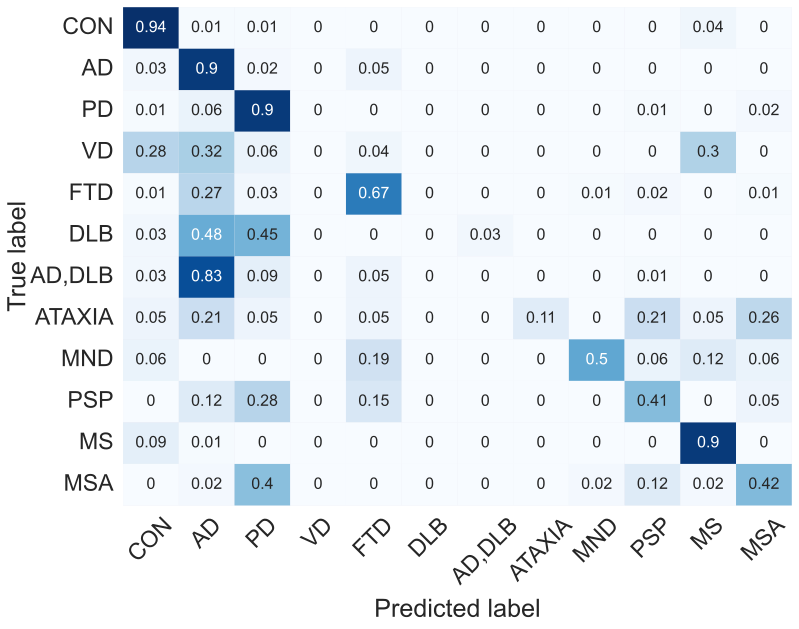

In [35]:
sns.set(font_scale=2.1)
list_of_dfs = []
full_preds = []
averages_f1 = []
confusions = []
jaccards = []

# alphabetic = ['AD', 'AD_CA','AD_VE','ATAXIA','BP','CON','DEM_SICC','DLB',  'FTD',
#               'MD','MND','MS', 'MSA','PD',  'PDD', 'PSP', 'SCHIZ', 'VD']
wanted = ['CON', 'AD', 'AD_CA', 'AD_VE', 'DEM_SICC', 'PD', 'PDD','DLB', 'VD',
          'FTD', 'MND', 'PSP','ATAXIA', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'DEM_SICC', 'PD', 'PDD','DLB', 'VD',
          'FTD', 'MND', 'PSP','ATAXIA', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'PD', 'PDD','DLB', 'VD',
          'FTD', 'MND', 'PSP','ATAXIA', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'PD', 'PDD', 'VD',
          'FTD', 'MND', 'PSP', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'PD', 'VD',
          'FTD', 'MND', 'PSP', 'MS','MSA' ,'MD','BP', 'SCHIZ']
wanted = ['CON', 'AD', 'PD', 'VD', 'FTD','AD,DLB','DLB','ATAXIA', 'MND', 'PSP', 'MS','MSA']
wanted = ['CON', 'AD', 'PD', 'VD', 'FTD','DLB','AD,DLB','DLB,SICC','ATAXIA', 'MND', 'PSP', 'MS','MSA'] #'AD,DLB'
wanted = ['CON', 'AD', 'PD', 'VD', 'FTD','DLB','AD,DLB','ATAXIA', 'MND', 'PSP', 'MS','MSA'] #'AD,DLB'
# wanted = ['CON', 'AD', 'PD', 'VD', 'FTD','DLB','ATAXIA', 'MND', 'PSP', 'MS','MSA'] #'AD,DLB'
for i in range(preds['pred_y_list_all'].shape[0]):
    print('fold: ',i)
    #print the prediction for the test for the nth fold
    firstfold_preds = preds['pred_y_list_all'][i][2]
    pred_df = pd.DataFrame(firstfold_preds, columns = wanted)
    b = np.zeros_like(pred_df.values)
    b[np.arange(len(pred_df)), pred_df.values.argmax(1)] = 1
    df1 = pd.DataFrame(b, columns = pred_df.columns).astype(int)
    compare = pd.DataFrame(df1.idxmax(1),columns=['predictions'])

    ## TRUTHS
    truths = np.load(path_truths, allow_pickle=True)#load(path_predictions)
    firstfold_truths = truths['true_y_list_all'][i][2]
    truth_df = pd.DataFrame(firstfold_truths, columns = wanted)
    compare['truths'] = truth_df.idxmax(1)
    full_preds.append(compare)
    
    ## F1-SCORE
    print('f1score')
    print(f1_score(compare['truths'], compare['predictions'], average='micro'))
    averages_f1.append(f1_score(compare['truths'], compare['predictions'], average='micro'))
    
    # print('nienke this is the format!')
    # display(compare)
    ## CONFUSION MATRIX
    cf_matrix= metrics.confusion_matrix(compare['truths'], compare['predictions'],
                                        labels = wanted)
    confusions.append(cf_matrix)

    ## JACCARD
    j_index = jaccard_score(y_true=compare['truths'],y_pred=compare['predictions'],labels=wanted,average=None)
    j_index_df = pd.DataFrame(j_index, columns= ['Jaccard'], index = wanted)
#     display(j_index_df)
    jaccards.append(j_index)
    
    ## CLASSIFICATION REPORT
    report = metrics.classification_report(compare['truths'], compare['predictions'], digits=3,output_dict=True, zero_division=1)
    report_df = pd.DataFrame(report).transpose()
    report_df = round(report_df,3)
    report_df['fold'] = i
    report_df = pd.concat([report_df,j_index_df],axis=1)
    wanted_plus = wanted.copy()
    new_items = ['accuracy', 'macro avg', 'weighted avg']
    wanted_plus.extend(new_items)
    report_df= report_df.reindex(wanted_plus)
    # display(report_df)
    list_of_dfs.append(report_df)

## F1-SCORE
average_f1 = np.average(averages_f1)

## JACCARD
# average_jaccard = np.array(jaccards).mean(axis=0)
# jaccard_df = pd.DataFrame(average_jaccard,columns=['Jaccard Index'],index=cols)
# jaccard_df = jaccard_df.round(decimals = 2)
# jaccard_df = jaccard_df.reindex(wanted)
# display(jaccard_df)

## CLASSIFICATION REPORT
full_report = pd.concat([list_of_dfs[0], list_of_dfs[1], list_of_dfs[2],list_of_dfs[3],list_of_dfs[4]])

full_report2 = full_report.groupby(level=0).mean()
full_report2 = full_report2.drop('fold',axis=1)
full_report2 = full_report2.reindex(wanted)
display(full_report2)
output_path = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/classification_report_{identifier}.xlsx'
full_report2.to_excel(output_path)  
# display(confusions)

## CONFUSION MATRIX
average_confusion = np.array(confusions).mean(axis=0)
vector = full_report2['support'].head(n=13).to_numpy()
perc_con = average_confusion / vector[:,None]
perc_con = np.round(perc_con, 2)
display(perc_con)

# perc_con[perc_con == 0] = str(float('0'))
# print(perc_con)
make_confusion_matrix(perc_con,# average_confusion,#
                      categories=wanted, 
                      cmap='Blues',
                      group_names=None,
                      count=True,
                      percent=False,
                      cbar=False,
                      xyticks=True,
                      xyplotlabels=True,
                      sum_stats=False,
                      figsize=(12,9),
                      title=None)

output_path_png = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/confusion_matrix_{identifier}.png'
output_path_pdf = f'/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{save_name}_{identifier}/confusion_matrix_{identifier}.pdf'
plt.savefig(output_path_png,bbox_inches="tight",dpi=600) 
plt.savefig(output_path_pdf,bbox_inches="tight",dpi=600) 
plt.show()
plt.close()


In [19]:
# full_preds
df = pd.concat(full_preds,axis=1)
# display(df)
output_path = '/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/60_clinical_history_5_years_1_observations_subset_{}/folds_compare.xlsx'.format(identifier)
df.to_excel(output_path)  

OSError: Cannot save file into a non-existent directory: '/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/60_clinical_history_5_years_1_observations_subset_20230721_151450_441856'

#### PLOTS

In [20]:
full_report3 = full_report.reset_index()
full_report3.columns = ['index','Precision','Recall','F1-score','support','fold','Jaccard']
full_report3

,index,Precision,Recall,F1-score,support,fold,Jaccard
0,CON,0.781,0.905,0.838,63.000,0,0.721519
1,AD,0.684,0.833,0.751,96.000,0,0.601504
2,PD,0.724,0.875,0.792,48.000,0,0.656250
3,VD,1.000,0.091,0.167,11.000,0,0.090909
4,FTD,0.711,0.711,0.711,38.000,0,0.551020
5,DLB,1.000,0.000,0.000,6.000,0,0.000000
6,"AD,DLB",1.000,0.000,0.000,20.000,0,0.000000
7,ATAXIA,1.000,0.000,0.000,4.000,0,0.000000
8,MND,1.000,0.000,0.000,3.000,0,0.000000
9,PSP,0.909,0.588,0.714,17.000,0,0.555556


In [21]:
full_report_melted = pd.melt(full_report3, id_vars=['index','support','fold'],
        value_vars=['Precision','Recall','F1-score','Jaccard'],
       var_name='metric', value_name='value')
a = ['accuracy','macro avg','weighted avg']
full_report_melted = full_report_melted[~full_report_melted['index'].isin(a)]
full_report_melted = full_report_melted.set_index('index')
display(full_report_melted)

,support,fold,metric,value
index,,,,
CON,63.0,0,Precision,0.781000
AD,96.0,0,Precision,0.684000
PD,48.0,0,Precision,0.724000
VD,11.0,0,Precision,1.000000
FTD,38.0,0,Precision,0.711000
DLB,6.0,0,Precision,1.000000
"AD,DLB",20.0,0,Precision,1.000000
ATAXIA,4.0,0,Precision,1.000000
MND,3.0,0,Precision,1.000000


In [22]:
# Say, "the default sans-serif font is COMIC SANS"
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"

In [23]:
display(full_report2)

,precision,recall,f1-score,support,Jaccard
CON,0.8034,0.9460,0.8684,63.0,0.768561
AD,0.6676,0.8892,0.7614,95.6,0.615543
PD,0.7164,0.8866,0.7910,47.6,0.654820
VD,1.0000,0.0182,0.0334,10.6,0.018182
FTD,0.6930,0.5896,0.6334,38.0,0.466113
DLB,1.0000,0.0000,0.0000,6.0,0.000000
"AD,DLB",1.0000,0.0000,0.0000,20.4,0.000000
ATAXIA,1.0000,0.0666,0.1000,3.4,0.066667
MND,0.9334,0.3666,0.4742,3.2,0.346667
PSP,0.5720,0.3940,0.4622,17.2,0.315150


78
138
26
25
12
43
4
18
53
12
11
10
3
['CON\nn=78', 'AD\nn=138', 'PD\nn=26', 'PDD\nn=25', 'VD\nn=12', 'FTD\nn=43', 'MND\nn=4', 'PSP\nn=18', 'MS\nn=53', 'MSA\nn=12', 'MD\nn=11', 'BP\nn=10', 'SCHIZ\nn=3']


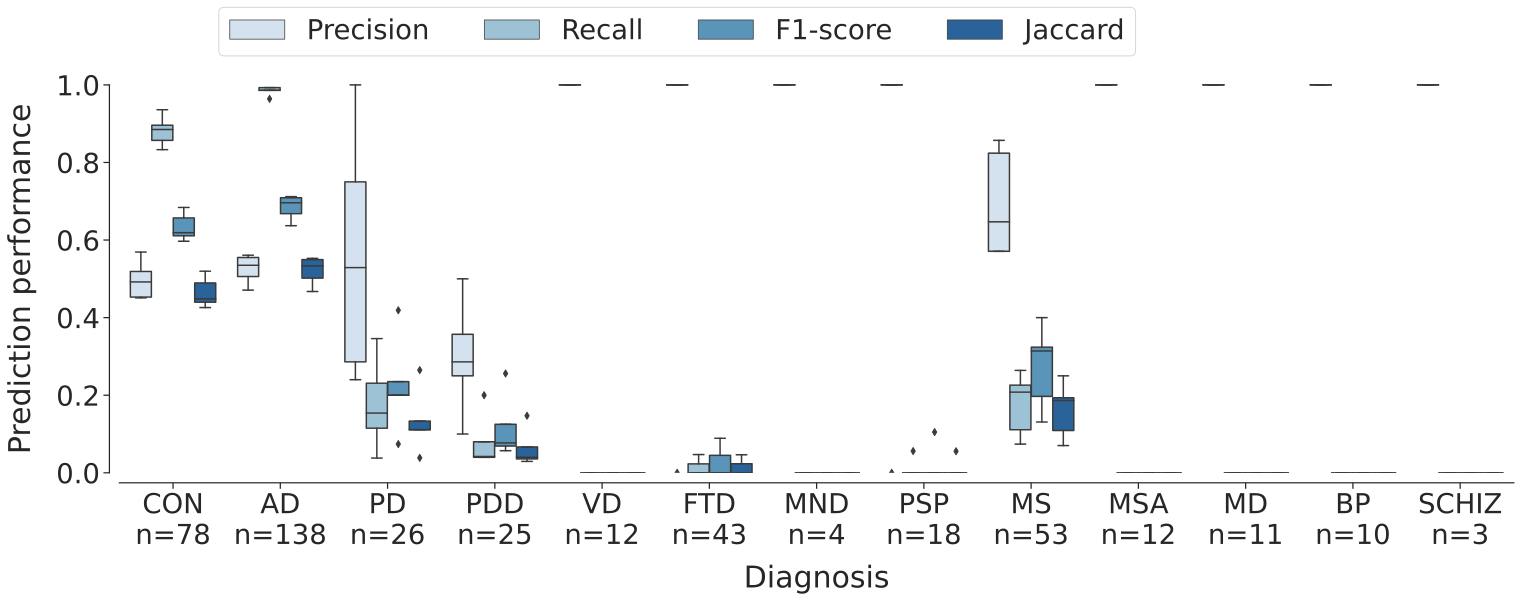

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(style="ticks", font_scale=2.5)

fig, ax = plt.subplots(figsize=(25, 7))
sns.boxplot(x=full_report_melted.index, y="value", hue="metric", data=full_report_melted, ax=ax,palette = 'Blues')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40)#, horizontalalignment='right')
# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)
# xticklabels = ax.get_xticklabels()
# ax.set_xticklabels(xticklabels, rotation = 45, ha="right")
# plt.xticks(rotation = 45)
# ax.set_xticklabels(ax.get_xticks(), rotation = 45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.legend(bbox_to_anchor=(0.4, 1.2), loc="upper center", ncol=4, borderaxespad=0)
# plt.legend(loc="upper center", ncol=4)
ax.set_xlabel("Diagnosis",labelpad=15)
ax.set_ylabel("Prediction performance",labelpad=20)
if observation == False:
    plt.suptitle('{} Years with {} observations. \n Micro F1-score: {}, average AUROC: {}'.format(n,m,round(average_f1,3),round(average_auroc,3)), fontsize=12)
elif observation == True and unique == False:
    plt.suptitle('{} observations. \n Micro F1-score: {}, average AUROC: {}'.format(n,round(average_f1,3),round(average_auroc,3)), fontsize=12)
elif observation == True and unique == True:
    plt.suptitle('{} unique observations. \n Micro F1-score: {}, average AUROC: {}'.format(n,round(average_f1,3),round(average_auroc,3)), fontsize=12)

plt.suptitle(None)
ax.set_ylim(0,1)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
sns.despine(offset=10, trim=False)

a=ax.get_xticks().tolist()
for i in range(len(a)):
#     print(i)
#     print(full_report2.index.tolist())
    print(round(full_report2['support'][i]))
    a[i]=full_report2.index.tolist()[i] + '\nn={}'.format(round(full_report2['support'][i]))
ax.set_xticklabels(a)
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[1] = 'Testing'
# ax.set_xticklabels(labels)
print([item.get_text() for item in ax.get_xticklabels()])
# ax.spines.left.set_bounds((0, 1))

output_path_png = '/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{}/classification_report_{}.png'.format(identifier,identifier)
output_path_pdf = '/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/temporal_model/results/{}/classification_report_{}.pdf'.format(identifier,identifier)
fig.savefig(output_path_png,bbox_inches="tight",dpi=600) 
fig.savefig(output_path_pdf,bbox_inches="tight",dpi=600) 
plt.show()
plt.close()

### old

In [18]:
# m = 1
# n = 5
# remove3 = True
# observation = False
# unique = False
# if remove3 == False and observation == False and unique == False:
#     save_name = 'clinical_history_{}_years_{}_observations'.format(str(n),str(m))
#     cols = ['AD', 'ATAXIA', 'BP', 'CON', 'FTD', 'MD', 'MND', 'MS',  'MSA', 'PD', 'PDD', 'PSP', 'SCHIZ', 'VD']
#     cols = ['AD', 'ATAXIA', 'BP', 'CON','DLB', 'FTD', 'MD', 'MND', 'MS',  'MSA', 'PD', 'PDD', 'PSP', 'SCHIZ', 'VD']
#     if m == 1 and n == 1:
#         identifier = '20220811_125749_549959' # Micro F1-score: 0.739, Macro F1-score: 0.504, average AUROC: 0.933
#         # without shuffle'20220811_091932_484522' 
#     elif m == 1 and n == 2:
#         identifier = '20220811_130315_572958' # Micro F1-score: 0.755, Macro F1-score: 0.531, average AUROC: 0.936
#         #without shuffle 20220811_092342_934865  
#     elif m == 1 and n == 3: ## WINNER
#         identifier = '20220811_130317_686429' # Micro F1-score: 0.765, Macro F1-score: 0.519, average AUROC: 0.942
#         #without shuffle 20220811_092456_948567 
#     elif m == 0 and n == 1:
#         identifier = '20220811_125912_299211' # Micro F1-score: 0.74, Macro F1-score: 0.51, average AUROC: 0.932
#         #without shuffle 20220811_092151_231509 
#     elif m == 0 and n == 2:
#         identifier = '20220811_125946_705098' # Micro F1-score: 0.745, Macro F1-score: 0.513, average AUROC: 0.935
#         #without shuffle 20220811_092753_431603
#     elif m == 0 and n == 3:
#         identifier = '20220811_130023_046260' # Micro F1-score: 0.761, Macro F1-score: 0.534, average AUROC: 0.932
#         #without shuffle 20220811_092848_136571
#     elif m == 0 and n == 4:
#         identifier = '20220811_144324_393381' # Micro F1-score: 0.75, Macro F1-score: 0.528, average AUROC: 0.933
#     elif m == 2 and n == 1:
#         identifier = '20220811_144525_941453' # Micro F1-score: 0.747, Macro F1-score: 0.509, average AUROC: 0.939
#     elif m == 2 and n == 2: 
#         identifier = '20220811_144530_960516' # Micro F1-score: 0.764, Macro F1-score: 0.54, average AUROC: 0.938

# if remove3==True and observation == False and unique == False:
#     save_name = 'clinical_history_{}_years_{}_observations_subset'.format(str(n),str(m))
#     cols = ['AD',  'BP', 'CON', 'FTD', 'MD', 'MS',  'MSA', 'PD', 'PDD', 'PSP', 'VD']
#     cols = ['AD', 'BP', 'CON','DLB', 'FTD', 'MD', 'MS',  'MSA', 'PD', 'PDD', 'PSP', 'VD']
#     if m == 1 and n == 1:
#         identifier = '20220811_135844_836666' # Micro F1-score: 0.758, Macro F1-score: 0.633, average AUROC: 0.94
#     elif m == 1 and n == 2:
#         identifier = '20220811_135926_067172' # Micro F1-score: 0.769, Macro F1-score: 0.647, average AUROC: 0.945
#     elif m == 1 and n == 3:
#         identifier = '20220811_135935_868183' # Micro F1-score: 0.769, Macro F1-score: 0.631, average AUROC: 0.947
#     elif m == 1 and n == 4: 
#         identifier = '20220811_144109_053395' # Micro F1-score: 0.787, Macro F1-score: 0.665, average AUROC: 0.95
#         # 80-10-10
#         identifier = '20220811_175226_704355' # Micro F1-score: 0.782, Macro F1-score: 0.656, average AUROC: 0.957
#     elif m == 1 and n == 5: 
#         identifier = '20220811_170556_266847' # Micro F1-score: 0.789, Macro F1-score: 0.654, average AUROC: 0.947
#         # 80-10-10 ## WINNER
#         identifier = '20220811_182451_264378' # Micro F1-score: 0.8, Macro F1-score: 0.674, average AUROC: 0.959
#     elif m == 0 and n == 1:
#         identifier = '20220811_135913_079098' # Micro F1-score: 0.753, Macro F1-score: 0.634, average AUROC: 0.941
#     elif m == 0 and n == 2:
#         identifier = '20220811_135936_892905' # Micro F1-score: 0.765, Macro F1-score: 0.645, average AUROC: 0.942
#     elif m == 0 and n == 3:
#         identifier = '20220811_135936_677540' # Micro F1-score: 0.77, Macro F1-score: 0.642, average AUROC: 0.943
#     elif m == 0 and n == 4:  
#         identifier = '20220811_144110_457439' # Micro F1-score: 0.765, Macro F1-score: 0.638, average AUROC: 0.944
#     elif m == 2 and n == 1:
#         identifier = '20220811_144915_412665' # Micro F1-score: 0.753, Macro F1-score: 0.62, average AUROC: 0.945
#     elif m == 2 and n == 2:
#         identifier = '20220811_144914_648664' # Micro F1-score: 0.771, Macro F1-score: 0.634, average AUROC: 0.945
#     elif m == 2 and n == 3:
#         identifier = '20220811_170446_921683' # Micro F1-score: 0.786, Macro F1-score: 0.654, average AUROC: 0.951

# if remove3==True and observation == True and unique == False:
#     save_name = 'clinical_history_{}_observations_subset'.format(str(n),str(m))
#     cols = ['AD',  'BP', 'CON', 'FTD', 'MD', 'MS',  'MSA', 'PD', 'PDD', 'PSP', 'VD']
#     if n == 2:
#         identifier = '20220811_160202_909428' # Micro F1-score: 0.755, Macro F1-score: 0.608, average AUROC: 0.942
#     elif n == 5:
#         identifier = '20220811_155640_151675' # Micro F1-score: 0.76, Macro F1-score: 0.623, average AUROC: 0.943
#     elif n == 7:
#         identifier = '20220811_160551_194857' # Micro F1-score: 0.772, Macro F1-score: 0.65, average AUROC: 0.946
#     elif n == 10:
#         identifier = '20220811_160250_666878' # Micro F1-score: 0.772, Macro F1-score: 0.644, average AUROC: 0.949
#     elif n == 15: 
# #         identifier = '20220811_161746_449357' # Micro F1-score: 0.787, Macro F1-score: 0.672, average AUROC: 0.953
#         #80-10-10 ## WINNER
#         identifier = '20220811_174255_533224' #Micro F1-score: 0.789, Macro F1-score: 0.677, average AUROC: 0.96
#     elif n == 20:
#         identifier = '20220811_162714_753150' # Micro F1-score: 0.78, Macro F1-score: 0.653, average AUROC: 0.95      

# if remove3==True and observation == True and unique == True:
#     save_name = 'clinical_history_{}_unique_observations_subset'.format(str(n),str(m))
#     cols = ['AD',  'BP', 'CON', 'FTD', 'MD', 'MS',  'MSA', 'PD', 'PDD', 'PSP', 'VD']
#     if n == 3:
#         # 60-20-20
#         identifier = '20220811_175922_954446' # Micro F1-score: 0.757, Macro F1-score: 0.632, average AUROC: 0.944
#         # 80-10-10
#         identifier = '20220811_182025_514685' # Micro F1-score: 0.774, Macro F1-score: 0.646, average AUROC: 0.954
#     elif n == 2:
#         # 80-10-10
#         identifier = '20220812_094756_293237' # 

#     elif n == 4:
#         # 80-10-10
#         identifier = '20220812_094152_479638' # 

#     elif n == 5:
#         identifier = '20220811_165554_100842' # Micro F1-score: 0.759, Macro F1-score: 0.626, average AUROC: 0.944
#     elif n == 7:
#         identifier = '20220811_171554_192040' # Micro F1-score: 0.772, Macro F1-score: 0.642, average AUROC: 0.949
#     elif n == 10:
#         identifier = '20220811_165412_414701' # Micro F1-score: 0.782, Macro F1-score: 0.669, average AUROC: 0.949
  
        
# print(save_name)
# print(identifier)

# identifier =  save_name + '_' + identifier
# print(identifier)
